In [1]:
import pandas as pd 
import geopandas as gpd 
import numpy as np 
import matplotlib.pyplot as plt

## Load the data

In [ ]:
# Hazard data
hazard = pd.read_csv(r"data\processed\Hazard.csv")

In [ ]:
# Exposure data
exposure = {
    'E1':pd.read_csv(r"data\processed\E1_AgricultureArea.csv"),
    'E2':pd.read_csv(r"data\processed\E2_AgricultureGDP.csv"),
    'E3':pd.read_csv(r"data\processed\E3_RuralPopulation.csv")
}

In [ ]:
# Sensitivity data
sensitivity = {
    'S1': pd.read_csv(r"data\processed\S1_AgricultureDependency.csv"), 
    'S2': pd.read_csv(r"data\processed\S2_AgricultureContribution.csv"),
    'S3': pd.read_csv(r"data\processed\S3_SmallholderPrevalence.csv")
}

In [ ]:
# Adaptation data
folder = r"data\processed"
fnames = ["A1_FarmersGroup.csv", "A2_ExtensionOfficers.csv", "A3_MillenialFarmers.csv", 
          "A4_HigherEducationLevel.csv", "A5_IrrigatedWetlands.csv", "A6_FinancialSystem.csv",
          "A7_IncomeDiversification.csv"]

adaptation = {}
for i in range(1, len(fnames)+1):
    adaptation[f'{fnames[i-1][:2]}'] = pd.read_csv(rf"{folder}\{fnames[i-1]}")

In [ ]:
# Shapefile 
shp = gpd.read_file(r"data\shp\BATAS_PROVINSI_DESEMBER_2019_DUKCAPIL.shp")
shp = shp.to_crs("EPSG:4326")

In [45]:
exposure['E3'] = exposure['E3'].drop(columns=['Unnamed: 0'])
exposure['E3']['% W Rural'] = exposure['E3']['Rural (W)'] / exposure['E3']['Rural (T)']

## Combine the data

In [46]:
province_names = {
    'Aceh':'ACEH',
    'Bali':'BALI',
    'Bangka Belitung':'KEPULAUAN BANGKA BELITUNG',
    'Banten':'BANTEN',
    'Bengkulu':'BENGKULU',
    'DI Yogyakarta':'DAERAH ISTIMEWA YOGYAKARTA',
    'DKI Jakarta':'DKI JAKARTA',
    'Gorontalo':'GORONTALO',
    'Jambi':'JAMBI',
    'Jawa Barat':'JAWA BARAT',
    'Jawa Tengah':'JAWA TENGAH',
    'Jawa Timur':'JAWA TIMUR',
    'Kalimantan Barat':'KALIMANTAN BARAT',
    'Kalimantan Selatan':'KALIMANTAN SELATAN',
    'Kalimantan Tengah':'KALIMANTAN TENGAH',
    'Kalimantan Timur':'KALIMANTAN TIMUR',
    'Kalimantan Utara':'KALIMANTAN UTARA',
    'Kepulauan Riau':'KEPULAUAN RIAU',
    'Lampung':'LAMPUNG',
    'Maluku':'MALUKU',
    'Maluku Utara':'MALUKU UTARA',
    'Nusa Tenggara Barat':'NUSA TENGGARA BARAT',
    'Nusa Tenggara Timur':'NUSA TENGGARA TIMUR',
    'Papua':'PAPUA',
    'Papua Barat':'PAPUA BARAT',
    'Riau':'RIAU',
    'Sulawesi Barat':'SULAWESI BARAT',
    'Sulawesi Selatan':'SULAWESI SELATAN',
    'Sulawesi Tengah':'SULAWESI TENGAH',
    'Sulawesi Tenggara':'SULAWESI TENGGARA',
    'Sulawesi Utara':'SULAWESI UTARA',
    'Sumatera Barat':'SUMATERA BARAT',
    'Sumatera Selatan':'SUMATERA SELATAN',
    'Sumatera Utara':'SUMATERA UTARA'

}

In [47]:
def normalization(df, var):

    xmin = df[var].min()
    xmax = df[var].max()

    norm = df[var].apply(lambda x: (x-xmin)/(xmax - xmin))
    return norm

In [58]:
hazard.columns

Index(['province', 'tmax_mean', 'heat_stress_mean', 'tmin_mean', 'tdiff_mean',
       'rx1_mean', 'rx5_mean', 'prcptot_mean', 'cdd_mean', 'cwd_mean', 'H'],
      dtype='object')

In [60]:
haz = hazard.copy()
haz = haz.rename(columns={
    'tmax_mean':'H1',
    'tmin_mean':'H2',
    'tdiff_mean':'H3',
    'heat_stress_mean':'H4',
    'rx1_mean':'H5',
    'rx5_mean':'H6',
    'prcptot_mean':'H7',
    'cdd_mean':'H8', 
    'cwd_mean':'H9'
})

In [49]:
exp = pd.merge(exposure['E1'], exposure['E2'], on='Province', suffixes=['_Area', '_GDP']).merge(exposure['E3'], on='Province')
exp = exp[['Province', 'E1', 'E2', 'E3']]
exp['Exposure'] = exp[['E1', 'E2', 'E3']].mean(axis=1)
exp['E'] = normalization(exp, 'Exposure')

In [50]:
sen = pd.merge(sensitivity['S1'], sensitivity['S2'], on='Province').merge(sensitivity['S3'], on='Province')
sen = sen[['Province', 'S1', 'S2', 'S3']]
sen['Sensitivity'] = sen[['S1', 'S2', 'S3']].mean(axis=1)
sen['S'] = normalization(sen, 'Sensitivity') 

In [51]:
adc = pd.merge(adaptation['A1'], adaptation['A2'], on='Province')\
    .merge(adaptation['A3'], on='Province').merge(adaptation['A4'], on='Province')\
    .merge(adaptation['A5'], on='Province').merge(adaptation['A6'], on='Province')\
    .merge(adaptation['A7'], on='Province', suffixes=['_1', '_2'])

adc = adc[['Province', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']]
adc['Adaptation'] = adc[['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']].mean(axis=1)
adc['A'] = normalization(adc, 'Adaptation')

In [64]:
indices = pd.merge(exp, sen, on='Province').merge(adc, on='Province')

In [65]:
indices = pd.merge(exp, sen, on='Province').merge(adc, on='Province')
indices['province'] = indices['Province'].apply(lambda x: province_names[x]
                                                if x in province_names.keys()
                                                else x)

indices = indices.merge(haz, on='province')

In [ ]:
import pandas as pd 
fnames = ["A1_FarmersGroup.csv", "A2_ExtensionOfficers.csv", "A3_MillenialFarmers.csv", 
          "A4_HigherEducationLevel.csv", "A5_IrrigatedWetlands.csv", "A6_FinancialSystem.csv",
          "A7_IncomeDiversification.csv"]

indices = {
    'H1': 'Max Temperature',
    'H2': 'Heat Stress',
    'H3': 'Min Temperature',
    'H4': 'Temperature Difference',
    'H5': 'Max 1-day Rainfall',
    'H6': 'Max 5-days Rainfall',
    'H7': 'Annual Precipitation',
    'H8': 'Consecutive Dry Days',
    'H9': 'Consecutive Wet Days',
    'E1': 'Agriculture Area',
    'E2': 'Agriculture GDP',
    'E3': 'Rural Population',
    'S1': 'Agriculture Dependency',
    'S2': 'Agriculture Contribution (GDP)',
    'S3': 'Smallholder Prevalence',
    'A1': 'Farmers Group',
    'A2': 'Extension Officer',
    'A3': 'Millenial Farmers',
    'A4': 'Higher Education Level',
    'A5': 'Irrigated Wetlands',
    'A6': 'Financial System',
    'A7': 'Income Diversification'
}

pd.DataFrame({'index': indices.keys(), 'desc': indices.values()}, index=range(len(indices.keys()))
             ).to_csv(r"data\final\index.csv")

## Calculation

### Risk and Vulnerability

In [66]:
# calculate Vulnerability as Sensitivity + (1 - Adaptation)
indices['Vulnerability'] = (indices['Exposure'] +  indices['Sensitivity'] + (1 - indices['Adaptation']))/3 
indices['V'] = normalization(indices, 'Vulnerability')

indices['Risk'] = indices[['H', 'E', 'V']].mean(axis=1)
indices['R'] = normalization(indices, 'Risk')

In [67]:
# risk of individual hazard
for i in range(1, 10):
    indices[f'R{i}'] = indices[[f'H{i}', 'E', 'V']].mean(axis=1)
    indices[f'R{i}'] = normalization(indices, f'R{i}')

### Contribution

In [68]:
def calculate_contribution(df, var, n):
    """ 
    df = dataframe
    var = index variable (A, S, E, or H)
    n = number of components
    """

    vars = [f"{var}{n}" for n in range(1, n+1)]

    contr = {}
    total = df[vars].sum().sum()

    values = []
    for v in vars:
        values.append(df[v].sum() / total * 100)

    contr['index'] = vars 
    contr['values'] = values 
    return contr 

In [69]:
comp = {'H':7,
        'E':3,
        'S':3,
        'A':7}
contr = {}
for key, num in comp.items():
    contr[key] = calculate_contribution(indices, key, num)

In [70]:
colors = ["#950404FF", "#E04B28FF", "#C38961FF", "#9F5630FF", 
          "#388F30FF", "#0F542FFF", "#007D82FF", "#004042FF"]
colors_3 = [colors[1], colors[4], colors[6]]

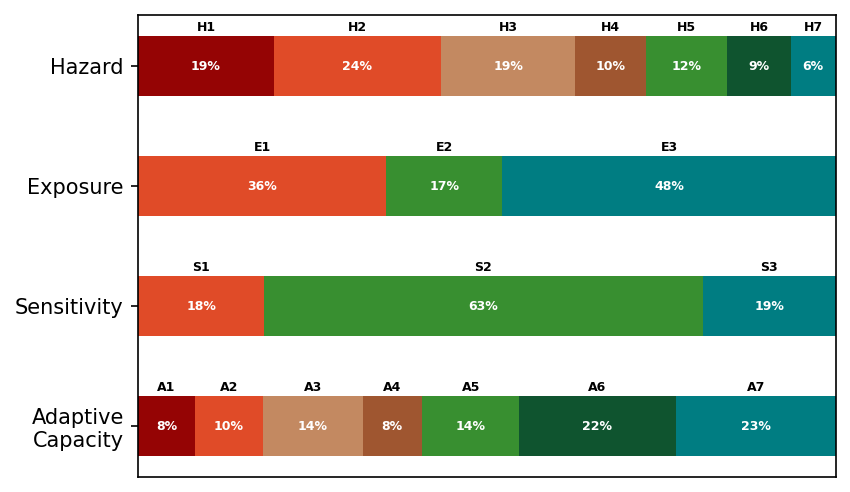

In [71]:
fig, ax = plt.subplots(figsize=(6,4), dpi=150)
ax.invert_yaxis()



for i, (key, data) in enumerate(contr.items()):
    starts = 0

    num_ind = np.shape(data['values'])[0]
    if num_ind == 8:
        col = colors
    elif num_ind == 7:
        col = colors[:8]
    else:
        col = colors_3
    # col = colors[1:] if np.shape(data['values'])[0] == 7 else colors_3

    for j, (idx, dat) in enumerate(zip(data['index'], data['values'])):
        width = dat  
        rects = ax.barh(key, width, left=starts, height=0.5, label=idx, color=col[j])
        for bar in rects:
            xpos = bar.get_x() + bar.get_width() / 2
            ypos = bar.get_y() + bar.get_height() / 2
            ax.text(xpos, ypos, f'{dat:.0f}%',
                ha='center', va='center', fontsize=6, color='white', fontweight='semibold')
            ax.text(xpos, ypos -0.325, idx,
                ha='center', va='center', fontsize=6, color='k', fontweight='bold')
        starts += dat


ax.set_xticks([])
ax.set_xlim([0, 100])
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['Hazard', 'Exposure', 'Sensitivity', 'Adaptive\nCapacity'])

fname = 'ComponentContribution'
fig.savefig(f'{fname}.png', dpi=200, bbox_inches='tight')
fig.savefig(f'{fname}.svg', dpi=200, bbox_inches='tight')
plt.show()

### Correlation

In [22]:
data = indices.copy()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

def correlation(df, var1, var2):

    # Drop rows where either var1 or var2 is NaN
    data = df[[var1, var2]].dropna()
    x, y = data[var1], data[var2]

    # ===== Pearson correlation =====
    corr, p_value = pearsonr(x, y)

    # ===== OLS Regression ===== 
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    # ===== Plotting =====
    fig, ax = plt.subplots(figsize=(5,5), dpi=150, constrained_layout=True)
    ax.scatter(x, y, color="k", alpha=0.8)

    # Regression line 
    x_vals = np.linspace(x.min(), x.max(), 100)
    X_plot = sm.add_constant(x_vals)
    y_pred = model.predict(X_plot)
    ax.plot(x_vals, y_pred, color='#476F84FF', lw=2)

    # variable name 
    mapping = {
        'H': 'Hazard',
        'E': 'Exposure',
        'V': 'Vulnerability',
        'S': 'Sensitivity',
        'R': 'Risk',
        'A': 'Adaptive Capacity'
        }
    
    def name_mapping(vars = [var1, var2]):
        new = []
        for v in vars:
            prefix = v[0]
            suffix = v[1:] 
            fullname = mapping[prefix]
            
            if suffix:
                fullname = f"{fullname}-{suffix}"
            
            new.append(fullname)
        return new
    new_var = name_mapping(vars=[var1, var2])

    ax.set_xlabel(new_var[0])
    ax.set_ylabel(new_var[1])
    
    fig.savefig(fr'Correlation\Correlation.{var2}_{var1}.png', dpi=150, bbox_inches='tight')

    # ===== Save the data =====
    result = {
        'vars': f'{var2}-{var1}',
        'corr': corr,
        'p-value': p_value,
        'r-squared': model.rsquared
    }
    return result

In [ ]:
risk_corr = []

vars = ['H', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'E', 'E1', 'E2', 'E3', 'V', 'S', 'S1', 'S2', 'S3']
adc_cols = [f'A{i}' for i in range(1, 8)]
vars = adc_cols

for i, var in enumerate(vars):
    risk_corr.append(correlation(data, var, 'R'))

risk_corr = pd.DataFrame(risk_corr)
display(risk_corr.sort_values(by='corr'))

In [25]:
# exp_corr = []

# vars = ['H', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'E', 'E1', 'E2', 'E3', 'V', 'S', 'S1', 'S2', 'S3']

# for i, var in enumerate(vars):
#     exp_corr.append(correlation(data, var, 'R'))

# exp_corr = pd.DataFrame(risk_corr)

## Visualization

### Indicator

In [24]:
data = indices.copy()

In [25]:
dat = {}

dat = {'labels':['R', 'V', 'H', 'E', 'S', 'A'],
       'data':data[['R', 'V', 'H', 'E', 'S', 'A']].values}

In [26]:
dat['data'].shape

(34, 6)

NameError: name 'cmap' is not defined

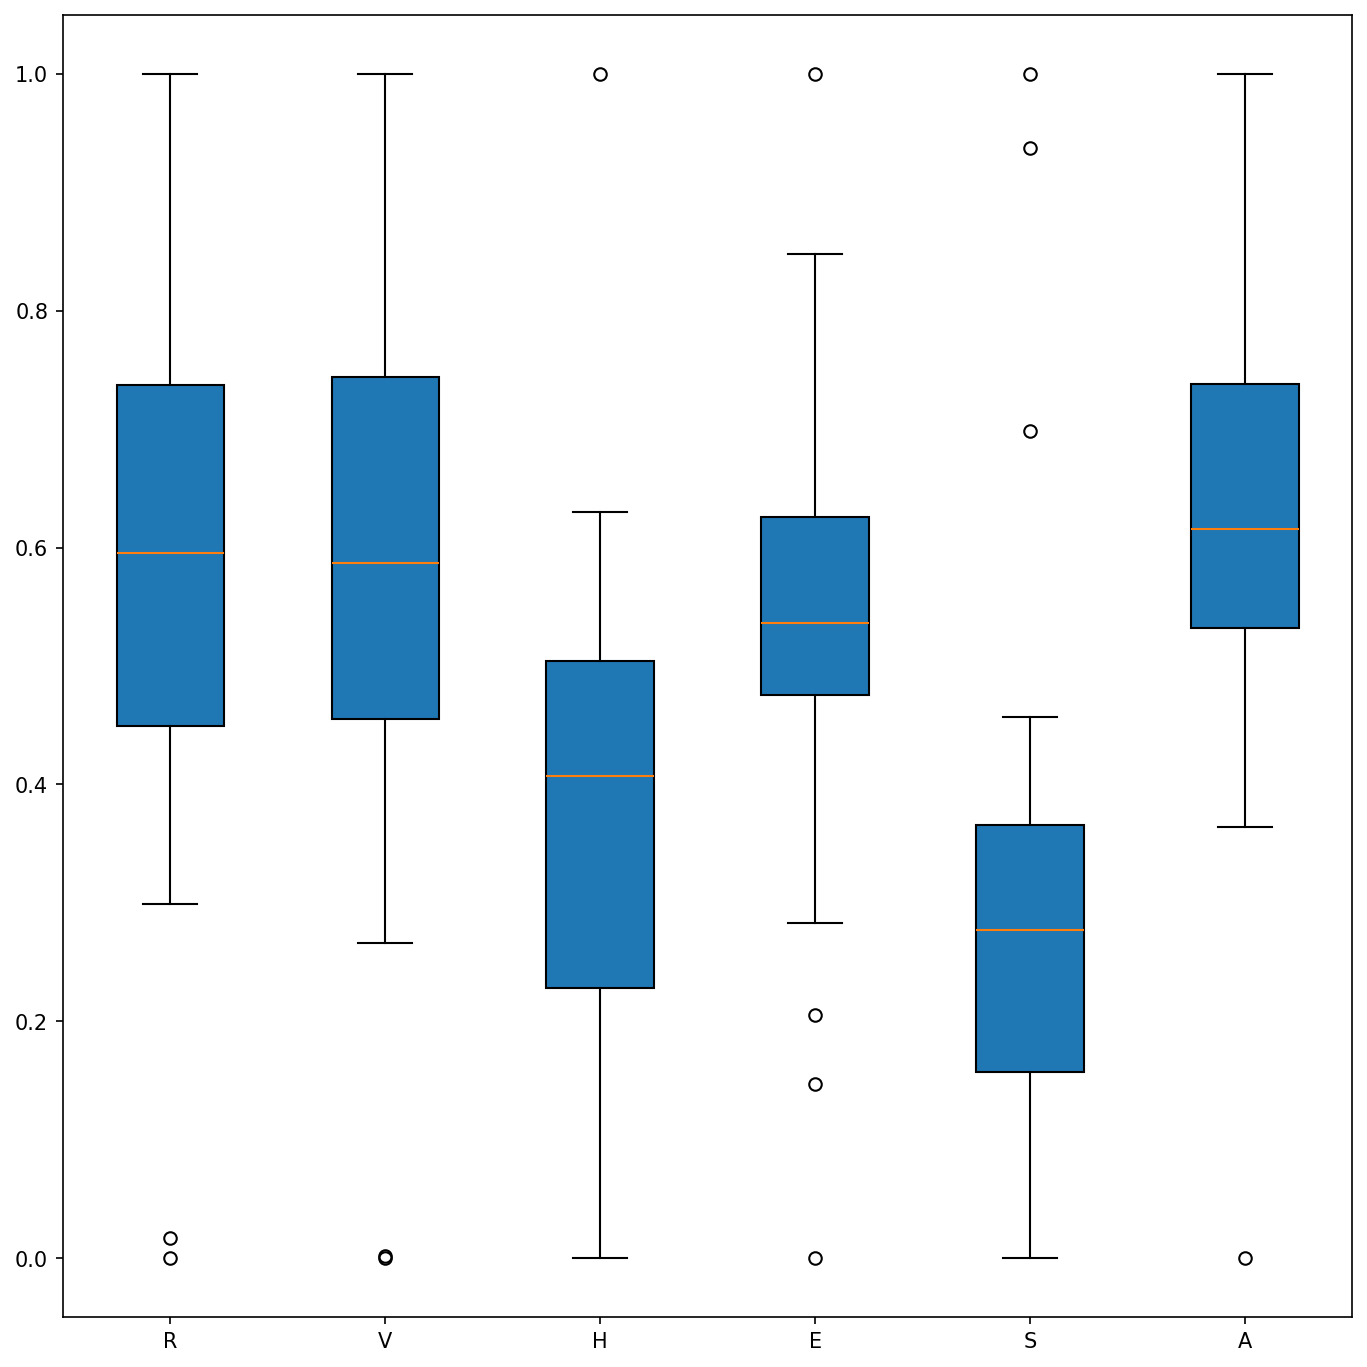

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1, 
                       dpi=150, constrained_layout=True, sharex=True)

bp_args = dict(patch_artist=True,return_type='dict', widths=0.4)

# Make the boxplots with patch_artist=True so boxes are Polygon patches
bp1 = ax.boxplot(dat['data'], patch_artist=True, labels=dat['labels'])

# # Pick a colormap
# from pypalettes import load_cmap
# cmap = load_cmap("GrandCanyon")

def color_boxes(bp, cmap):
    bp = bp.values[0]
    boxes = bp['boxes']
    n = len(boxes)
    colors = [cmap(i/n) for i in range(n)]
    for patch, color in zip(boxes, colors):
        patch.set_facecolor(color)   # fill color
        patch.set_edgecolor("black") # box edge
        patch.set_alpha(0.8)

    # Style medians, whiskers, caps
    for median in bp['medians']:
        median.set_color("k")
        median.set_linewidth(1)

    for whisker in bp['whiskers']:
        whisker.set_color("black")

    for cap in bp['caps']:
        cap.set_color("black")
    
    for flier, color in zip(bp['fliers'], colors):
        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor("black")

# # Apply
color_boxes(bp1, cmap)
# color_boxes(bp2, cmap)
# color_boxes(bp3, cmap)

# # Labels
# ax[0].set_ylabel('Risk')
# ax[1].set_ylabel('Exposure')
# ax[2].set_ylabel('Vulnerability')

# for i in range(3):
#     ax[i].set_xlabel('')
#     ax[i].set_title('')
#     ax[i].grid(False)

# fig.suptitle('')
# fig.savefig('result\Distribution_Provinsce.png', dpi=200, bbox_inches='tight')
# fig.savefig('result\Distribution_Provincse.svg', dpi=200, bbox_inches='tight')
# plt.show()

### Province Level

In [100]:
region_map = {
    'Aceh': 'Sumatera',
    'Sumatera Utara': 'Sumatera',
    'Sumatera Barat': 'Sumatera',
    'Riau': 'Sumatera',
    'Kepulauan Riau': 'Sumatera',
    'Jambi': 'Sumatera',
    'Sumatera Selatan': 'Sumatera',
    'Bangka Belitung':'Sumatera',
    'Bengkulu': 'Sumatera',
    'Lampung': 'Sumatera',
    'DKI Jakarta':'Jawa-Bali',
    'Jawa Barat': 'Jawa-Bali',
    'Banten': 'Jawa-Bali',
    'Jawa Tengah': 'Jawa-Bali',
    'DI Yogyakarta': 'Jawa-Bali',
    'Jawa Timur': 'Jawa-Bali',
    'Bali': 'Jawa-Bali',
    'Nusa Tenggara Barat': 'MPNT',
    'Nusa Tenggara Timur': 'MPNT',
    'Kalimantan Barat': 'Kalimantan',
    'Kalimantan Tengah': 'Kalimantan',
    'Kalimantan Selatan': 'Kalimantan',
    'Kalimantan Timur': 'Kalimantan',
    'Kalimantan Utara': 'Kalimantan',
    'Sulawesi Utara': 'Sulawesi',
    'Gorontalo': 'Sulawesi',
    'Sulawesi Tengah': 'Sulawesi',
    'Sulawesi Barat': 'Sulawesi',
    'Sulawesi Selatan': 'Sulawesi',
    'Sulawesi Tenggara': 'Sulawesi',
    'Maluku': 'MPNT',
    'Maluku Utara': 'MPNT',
    'Papua Barat': 'MPNT',
    'Papua': 'MPNT',
}


region_colors = {
    'Sumatera':'#521E0FFF',
    'Jawa-Bali':'#9C593EFF',
    'Kalimantan':'#DDA569FF',
    'Sulawesi':'#3F4330FF',
    'Nusa Tenggara':'#8E7E3CFF',
    'Maluku':'#2A4866FF',
    'Papua':'#6592B0FF'
}


data = indices.copy()
data['Region'] = data['Province'].map(region_map)

In [101]:
# data = data.groupby(['Region'])[['R', 'E', 'V', 'S', 'A']].sum().reset_index()
# data['Color'] = data['Region'].map(region_colors)

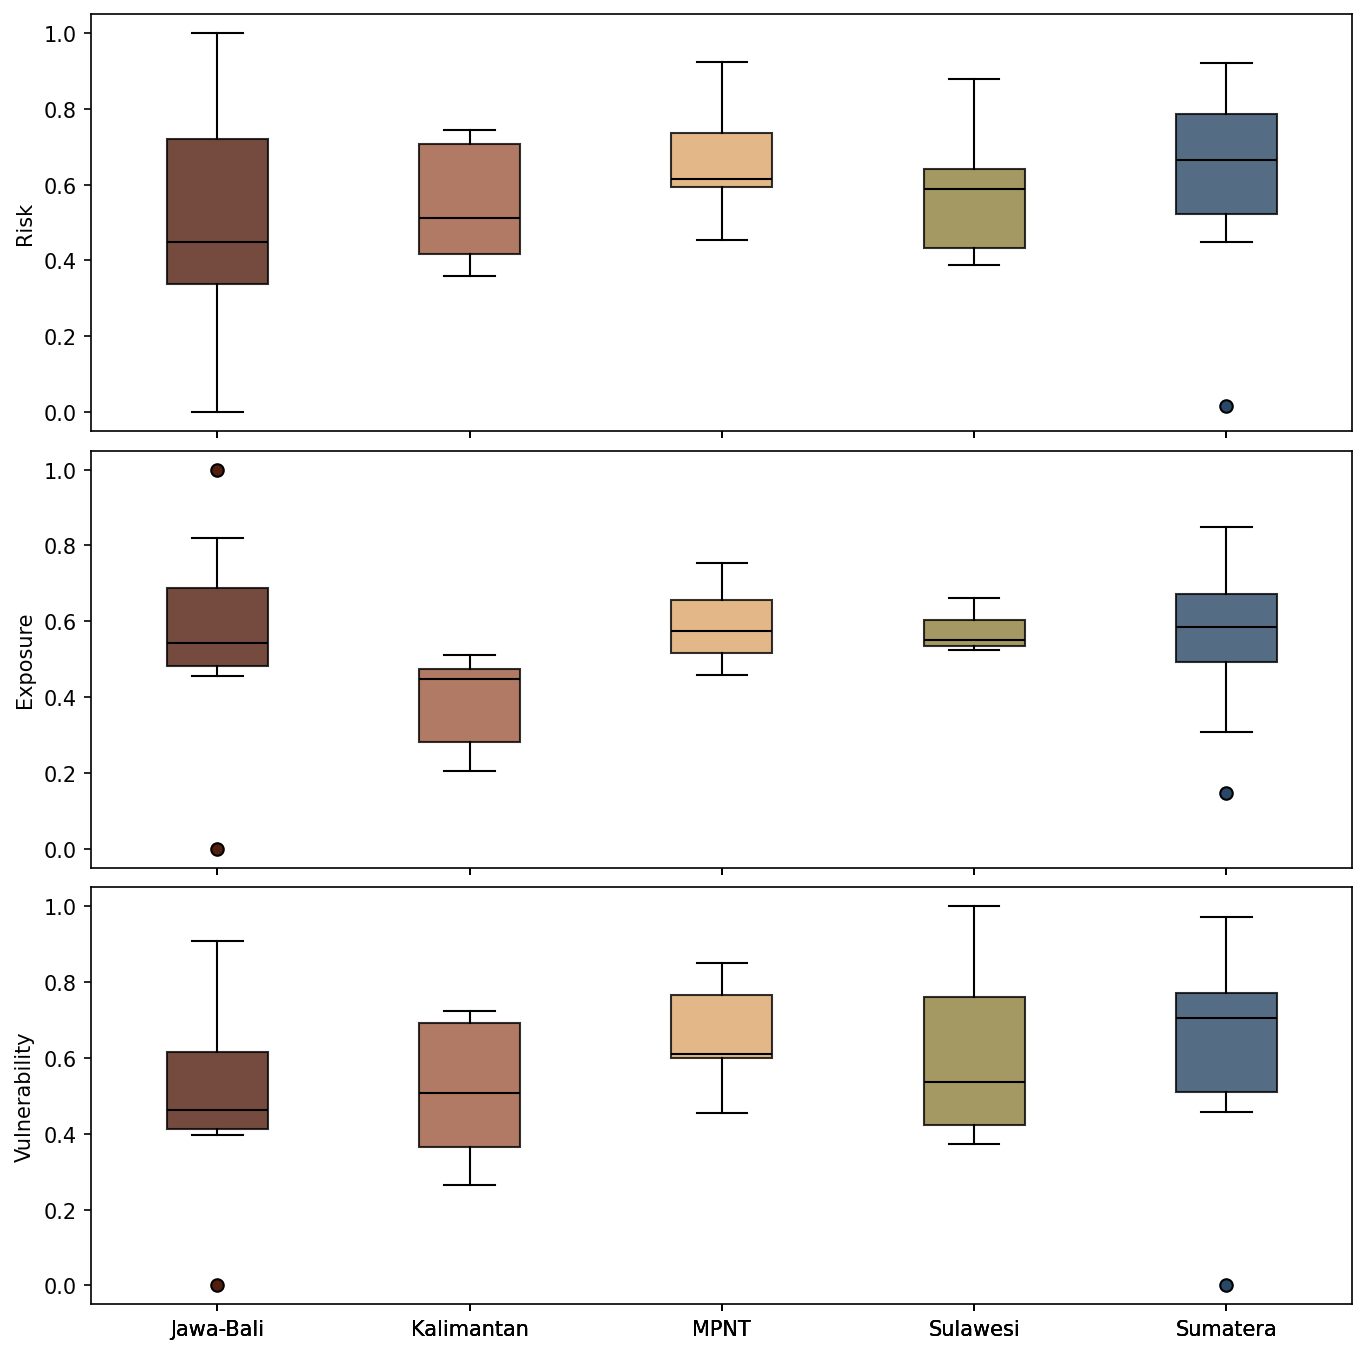

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 9), nrows=3, ncols=1, 
                       dpi=150, constrained_layout=True, sharex=True)

bp_args = dict(patch_artist=True,return_type='dict', widths=0.4)

# Make the boxplots with patch_artist=True so boxes are Polygon patches
bp1 = data.boxplot(column='R', by='Region', ax=ax[0], **bp_args)
bp2 = data.boxplot(column='E', by='Region', ax=ax[1], **bp_args)
bp3 = data.boxplot(column='V', by='Region', ax=ax[2], **bp_args)

# Pick a colormap
from pypalettes import load_cmap
cmap = load_cmap("GrandCanyon")

def color_boxes(bp, cmap):
    bp = bp.values[0]
    boxes = bp['boxes']
    n = len(boxes)
    colors = [cmap(i/n) for i in range(n)]
    for patch, color in zip(boxes, colors):
        patch.set_facecolor(color)   # fill color
        patch.set_edgecolor("black") # box edge
        patch.set_alpha(0.8)

    # Style medians, whiskers, caps
    for median in bp['medians']:
        median.set_color("k")
        median.set_linewidth(1)

    for whisker in bp['whiskers']:
        whisker.set_color("black")

    for cap in bp['caps']:
        cap.set_color("black")
    
    for flier, color in zip(bp['fliers'], colors):
        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor("black")

# Apply
color_boxes(bp1, cmap)
color_boxes(bp2, cmap)
color_boxes(bp3, cmap)

# Labels
ax[0].set_ylabel('Risk')
ax[1].set_ylabel('Exposure')
ax[2].set_ylabel('Vulnerability')

for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_title('')
    ax[i].grid(False)

fig.suptitle('')
# fig.savefig('result\Distribution_Province.png', dpi=200, bbox_inches='tight')
# fig.savefig('result\Distribution_Province.svg', dpi=200, bbox_inches='tight')
plt.show()

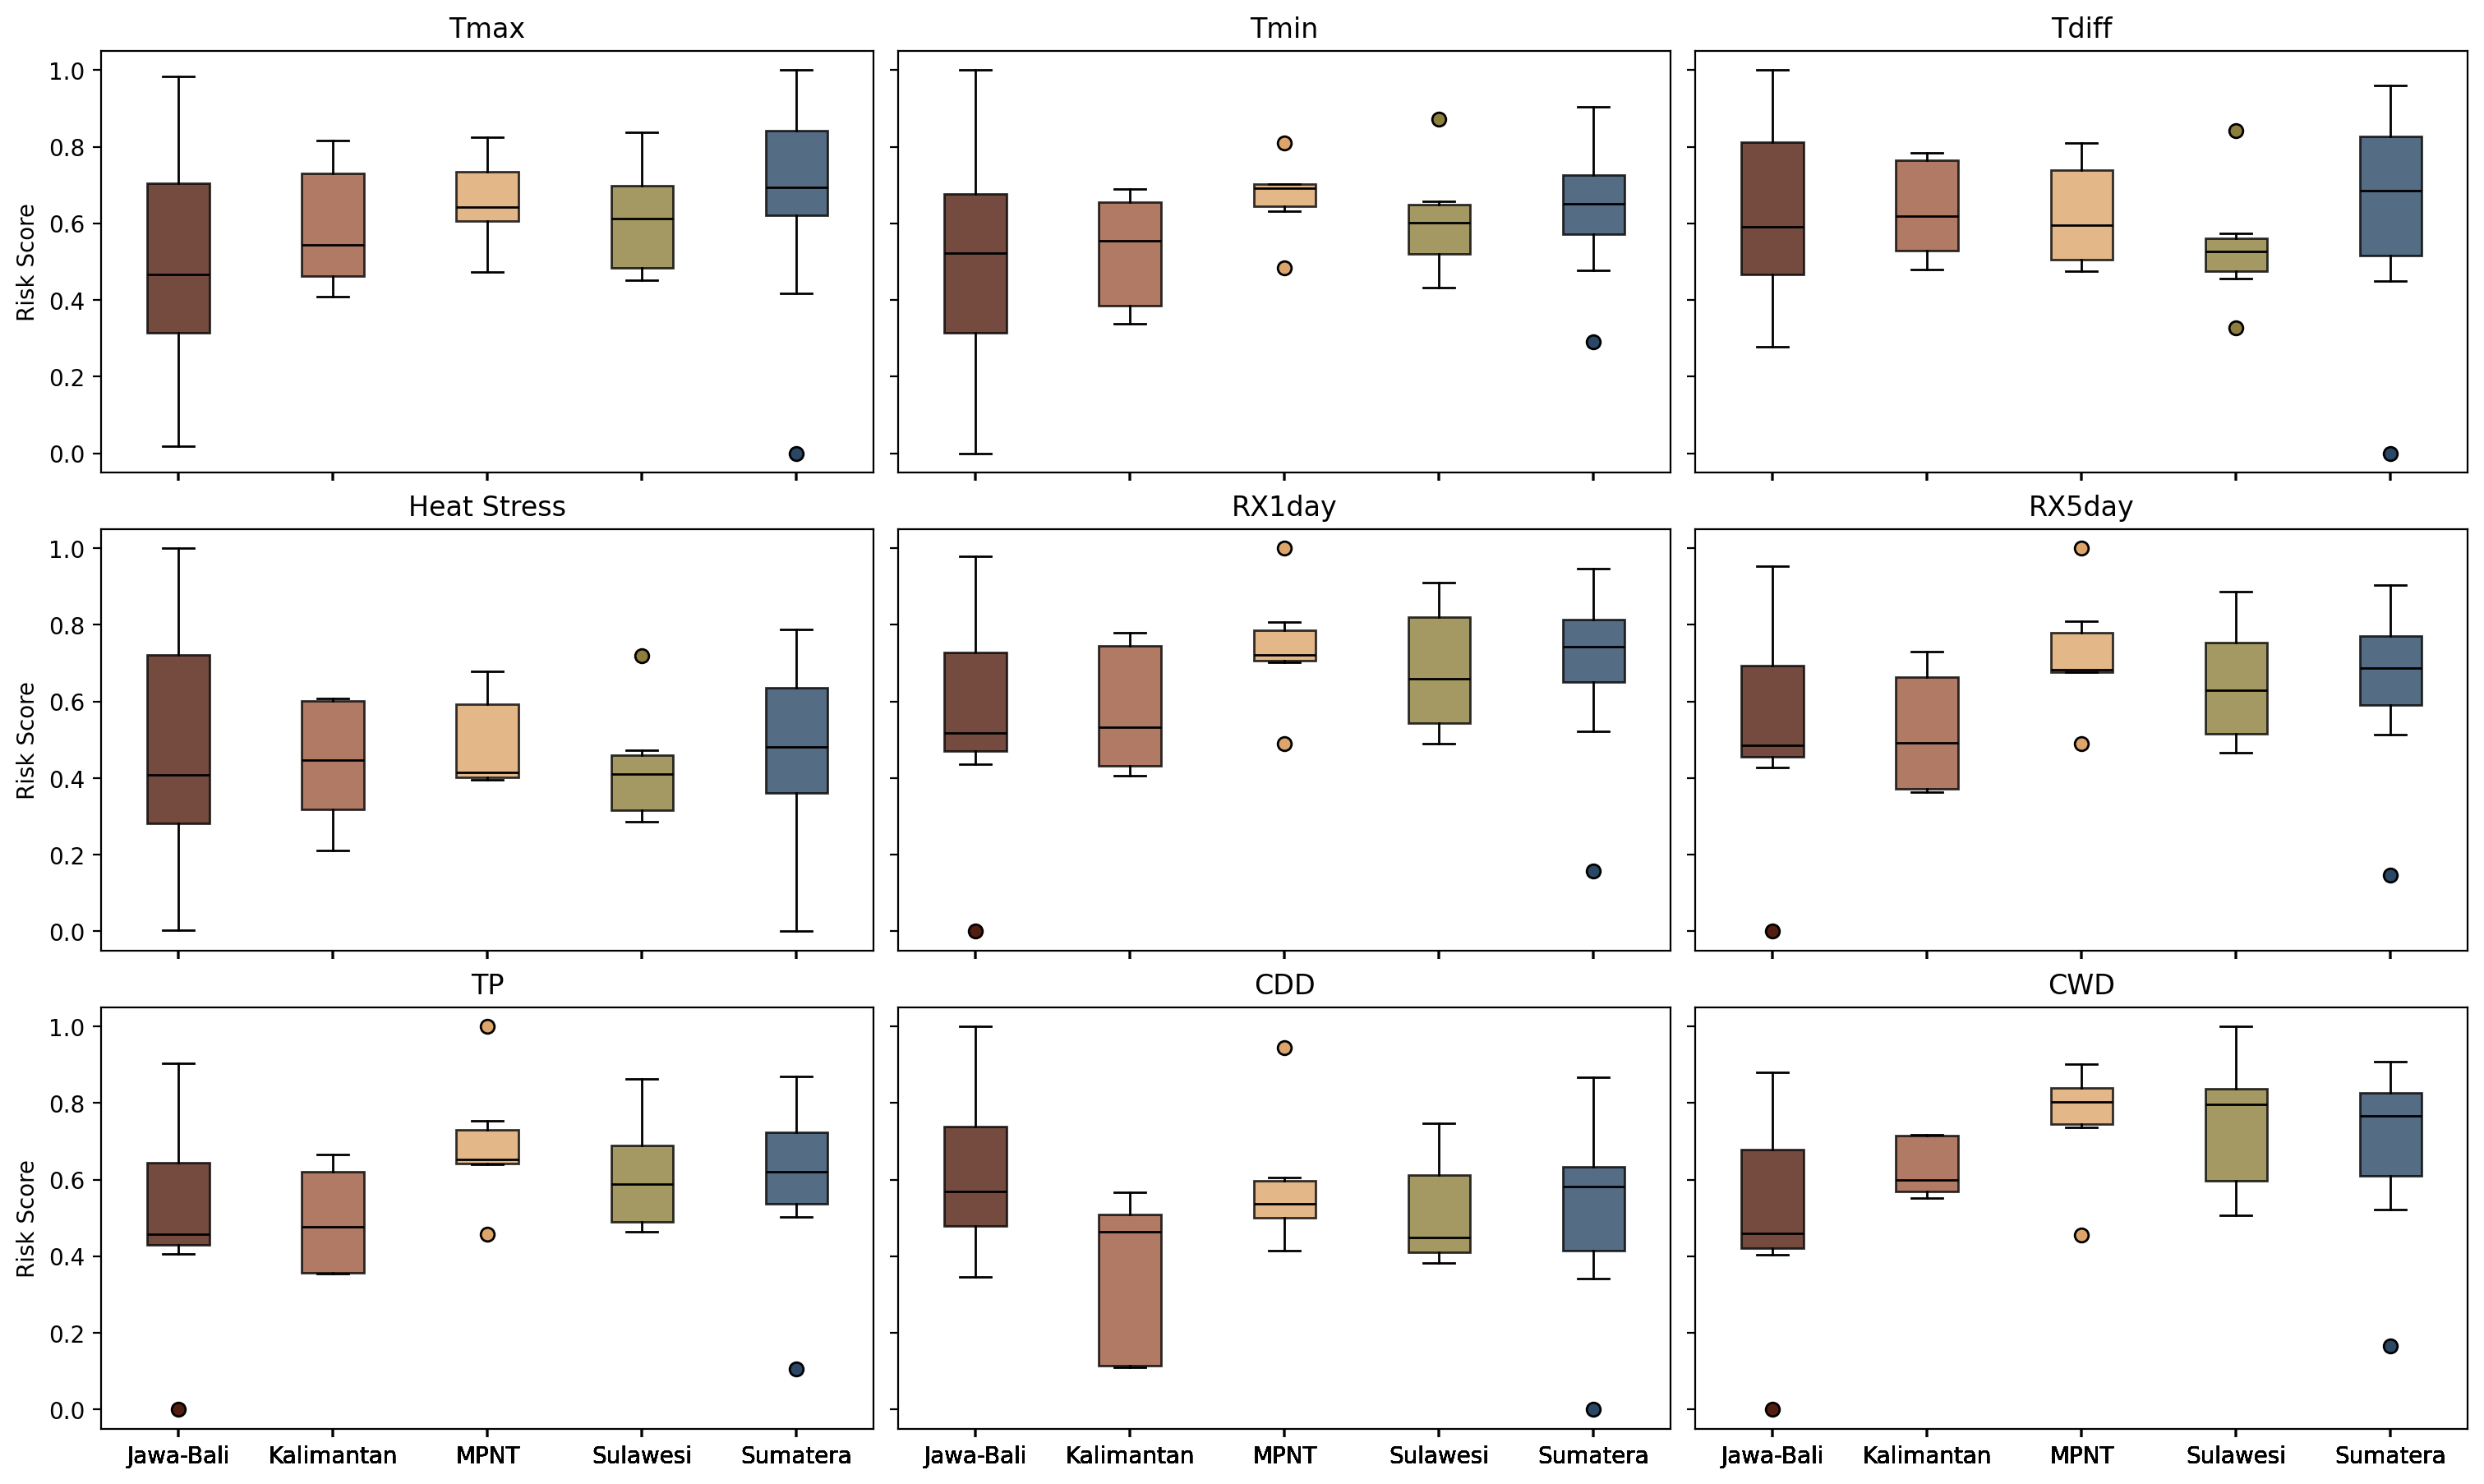

In [109]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pypalettes import load_cmap

fig, ax = plt.subplots(figsize=(15, 9), nrows=3, ncols=3,  sharey=True,
                       dpi=200, constrained_layout=True, sharex=True)
ax = ax.flatten()

bp_args = dict(patch_artist=True, return_type='dict', widths=0.4)
cmap = load_cmap("GrandCanyon")

def color_boxes(bp, cmap):
    bp = bp.values[0]
    boxes = bp['boxes']
    n = len(boxes)
    colors = [cmap(i/n) for i in range(n)]
    for patch, color in zip(boxes, colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")
        patch.set_alpha(0.8)

    for median in bp['medians']:
        median.set_color("k")
        median.set_linewidth(1)
    for whisker in bp['whiskers']:
        whisker.set_color("black")
    for cap in bp['caps']:
        cap.set_color("black")
    for flier, color in zip(bp['fliers'], colors):
        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor("black")


risk_variabel = []

risk_variabel = ['Tmax', 'Tmin', 'Tdiff', 'Heat Stress', 'RX1day', 'RX5day', 'TP', 'CDD', 'CWD']

for i in range(9):
    bp = data.boxplot(column=f'R{i+1}', by='Region', ax=ax[i], **bp_args)
    color_boxes(bp, cmap)

    if i in [0, 3, 6]:
        ax[i].set_ylabel('Risk Score')
    ax[i].set_title('')
    ax[i].grid(False)
    ax[i].set_xlabel('')
    ax[i].set_title(risk_variabel[i])
    # ax[i].tick_params(axis='x', labelsize=8)

fig.suptitle('')
fname = 'Distribution_Province_Risk'
fig.savefig(f'{fname}.png', dpi=200, bbox_inches='tight')
fig.savefig(f'{fname}.svg', dpi=200, bbox_inches='tight')

plt.show()

In [ ]:
indices.to_csv('data\final\indicator.csv', index=False)

### Region Level

In [29]:
region_map = {
    'Aceh': 'Western',
    'Sumatera Utara': 'Western',
    'Sumatera Barat': 'Western',
    'Riau': 'Western',
    'Kepulauan Riau': 'Western',
    'Jambi': 'Western',
    'Sumatera Selatan': 'Western',
    'Bangka Belitung':'Western',
    'Bengkulu': 'Western',
    'Lampung': 'Western',
    'DKI Jakarta':'Western',
    'Jawa Barat': 'Western',
    'Banten': 'Western',
    'Jawa Tengah': 'Western',
    'DI Yogyakarta': 'Western',
    'Jawa Timur': 'Western',
    'Bali': 'Eastern',
    'Nusa Tenggara Barat': 'Eastern',
    'Nusa Tenggara Timur': 'Eastern',
    'Kalimantan Barat': 'Western',
    'Kalimantan Tengah': 'Western',
    'Kalimantan Selatan': 'Western',
    'Kalimantan Timur': 'Western',
    'Kalimantan Utara': 'Western',
    'Sulawesi Utara': 'Eastern',
    'Gorontalo': 'Eastern',
    'Sulawesi Tengah': 'Eastern',
    'Sulawesi Barat': 'Eastern',
    'Sulawesi Selatan': 'Eastern',
    'Sulawesi Tenggara': 'Eastern',
    'Maluku': 'Eastern',
    'Maluku Utara': 'Eastern',
    'Papua Barat': 'Eastern',
    'Papua': 'Eastern',
}

# 
region_colors = {
    'Western':'#006A8EFF',
    'Eastern':'#B1283AFF',
}


data = indices.copy()
data = data[['Province', 'R', 'E', 'V', 'S', 'A']]
data['Region'] = data['Province'].map(region_map)

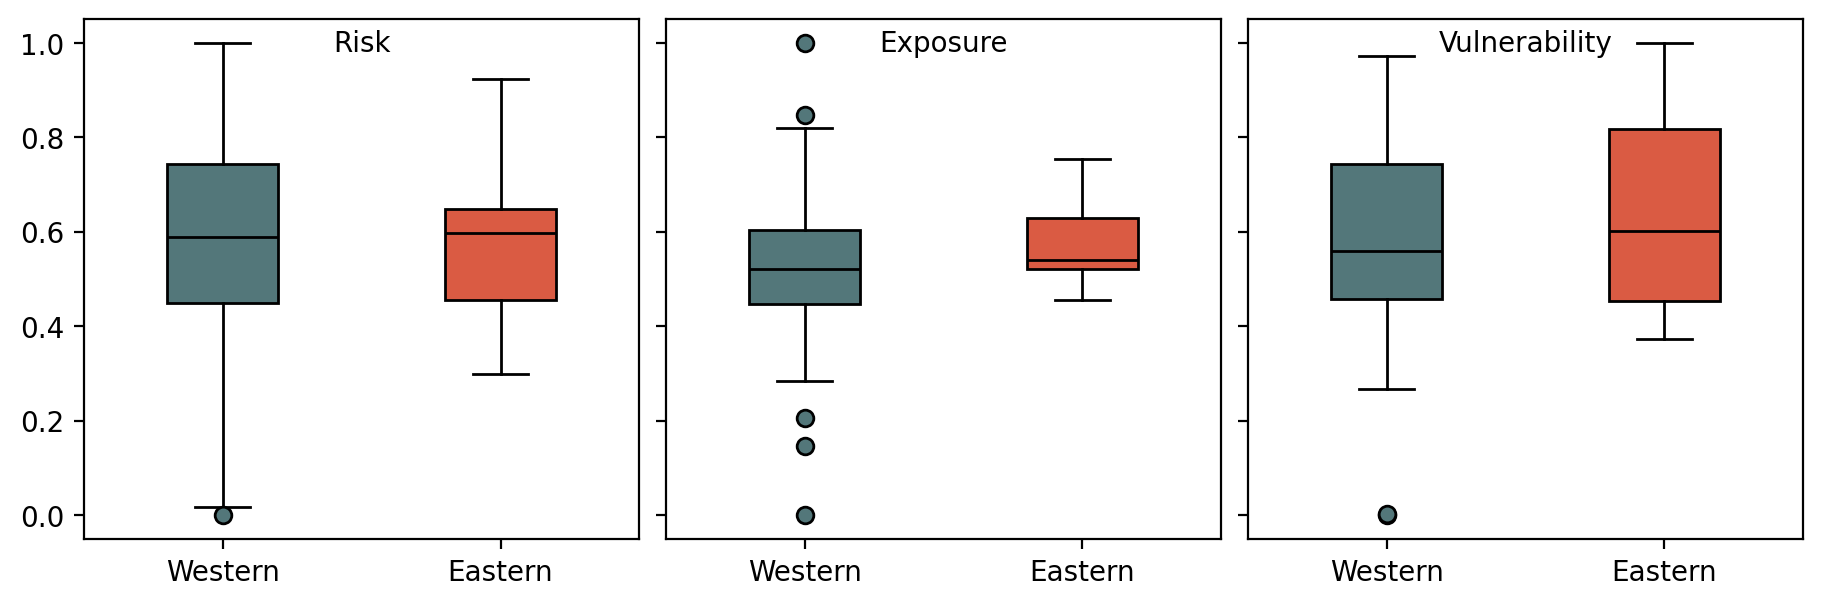

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 3), nrows=1, ncols=3, 
                       dpi=200, constrained_layout=True, sharey=True)

bp_args = dict(patch_artist=True,return_type='dict', widths=0.4)

# Make the boxplots with patch_artist=True so boxes are Polygon patches
bp1 = data.boxplot(column='R', by='Region', ax=ax[0], **bp_args)
bp2 = data.boxplot(column='E', by='Region', ax=ax[1], **bp_args)
bp3 = data.boxplot(column='V', by='Region', ax=ax[2], **bp_args)

# colormap
from pypalettes import load_cmap


def color_boxes(bp, cmap):
    bp = bp.values[0]
    boxes = bp['boxes']
    n = len(boxes)
    colors = ["#DA5B43FF", "#53777AFF"]
    for patch, color in zip(boxes, colors):
        patch.set_facecolor(color)   # fill color
        patch.set_edgecolor("black") # box edge
        patch.set_alpha(1)

    # Style medians, whiskers, caps
    for median in bp['medians']:
        median.set_color("k")
        median.set_linewidth(1)

    for whisker in bp['whiskers']:
        whisker.set_color("black")

    for cap in bp['caps']:
        cap.set_color("black")
    
    for flier, color in zip(bp['fliers'], colors):
        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor("black")

# Apply
color_boxes(bp1, cmap)
color_boxes(bp2, cmap)
color_boxes(bp3, cmap)

# Labels
for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_title('')
    ax[i].grid(False)
    ax[i].invert_xaxis()

# Annotate

ax[0].text(1.5, 1, 'Risk', va='center', ha='center')
ax[1].text(1.5, 1, 'Exposure', va='center', ha='center')
ax[2].text(1.5, 1, 'Vulnerability', va='center', ha='center')
fig.suptitle('')
fig.savefig('result\Distribution_Region.png', dpi=200, bbox_inches='tight')
fig.savefig('result\Distribution_Region.svg', dpi=200, bbox_inches='tight')
plt.show()

### By Risk Level

In [52]:
ag_land = exposure['E1'][['Province', 'Mean', 'STD']].copy()
ag_land = ag_land.rename(columns={'Mean':'Area', 'STD':'Area STD'})

ag_gdp = exposure['E2'].copy().rename(columns={'Mean':'GDP', 'STD':'GDP STD'})
population = exposure['E3']
data = indices[['Province', 'R']].copy()


data = data.merge(ag_land, on='Province') \
        .merge(ag_gdp[['Province', 'GDP', 'GDP STD']], on='Province') \
        .merge(population, on='Province')

In [53]:
def set_category(df, var, col='Level', n=5):
    q = df[var].quantile([0.2, 0.4, 0.6, 0.8]).values

    def get_cat(row):
        if row[var] <= q[0]:
            return 'Very Low'
        elif row[var] <= q[1]:
            return 'Low'
        elif row[var] <= q[2]:
            return 'Medium'
        elif row[var] <= q[3]:
            return 'High'
        else:
            return 'Very High'

    df.loc[:, col] = df.apply(get_cat, axis=1)
    return df


In [54]:
data = set_category(data, 'R', n=5)

In [58]:
data.columns

Index(['Province', 'R', 'Area', 'Area STD', 'GDP', 'GDP STD', 'City (M)',
       'City (W)', 'City (T)', 'Rural (M)', 'Rural (W)', 'Rural (T)',
       'Total (M)', 'Total (W)', 'Total', '% Rural (T)', '% Rural (M)',
       '% Rural (W)', 'E3', '% W Rural', 'Level'],
      dtype='object')

In [59]:

affected_data = data.groupby('Level') \
                    .agg({
                        'Province': 'count',
                        'GDP': 'sum',
                        'Area': 'sum',
                        'Rural (T)': 'sum',
                        'Rural (M)':'sum',
                        'Rural (W)':'sum'
                    }).reset_index()
affected_data = affected_data.rename(columns={'Rural (T)': 'Rural Population'})

affected_data['GDP'] = affected_data['GDP'] / 1e7
affected_data['Area'] = affected_data['Area'] / 1e4
affected_data['Rural Population'] = affected_data['Rural Population'] / 1e6

In [66]:
affected_data['Male'] = affected_data['Rural (M)'] / (affected_data['Rural Population']*1e6)
affected_data['Female'] = affected_data['Rural (W)'] / (affected_data['Rural Population']*1e6) 

In [67]:
affected_data

,Level,Province,GDP,Area,Rural Population,Rural (M),Rural (W),Male,Female
0,High,7,17.420767,11.852892,18.772839,9630996.0,9141843.0,0.513028,0.486972
1,Low,7,12.932603,4.541675,14.417065,7374558.0,7042507.0,0.511516,0.488484
2,Medium,6,14.108898,6.949402,20.646575,10472500.0,10174077.0,0.507227,0.492773
3,Very High,7,58.454927,11.656331,61.485386,30994254.0,30491133.0,0.504091,0.495909
4,Very Low,7,6.259262,1.633040,4.928161,2494621.0,2433540.0,0.506197,0.493803


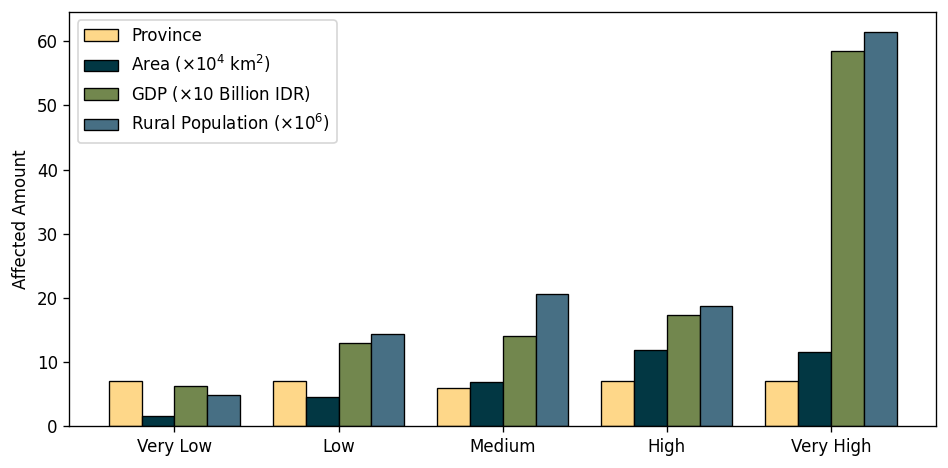

In [ ]:
df = affected_data.copy()
order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df['Level'] = pd.Categorical(df['Level'], categories=order, ordered=True)
df = df.sort_values('Level')

# Variables to plot
cols = ['Province', 'Area', 'GDP', 'Rural Population']
label = ['Province', r'Area ($\times 10^{4}$ km$^2$)', r'GDP ($\times 10$ Billion IDR)', r'Rural Population ($\times 10^{6}$)']
colors = ["#FED789FF", "#023743FF", "#72874EFF", "#476F84FF", "#A4BED5FF", "#453947FF"]

# Set up bar positions
x = np.arange(len(df['Level']))  # positions for levels
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(8,4), dpi=120)

# Plot each variable side by side
for i, col in enumerate(cols):
    ax.bar(x + i*width, df[col], width, label=label[i], color=colors[i], edgecolor='k', linewidth=0.8)

# Customize x-axis
ax.set_xticks(x + width*(len(cols)-1)/2)  # center tick labels
ax.set_xticklabels(df['Level'])

# Labels and legend
ax.set_ylabel("Affected Amount")
ax.legend()

fig.savefig('result\Affected_Amount.png', dpi=200, bbox_inches='tight')
fig.savefig('result\Affected_Amount.svg', dpi=200, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Indicator Map

In [122]:
data = indices.copy()

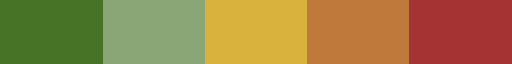

In [ ]:
# Define 5 colors for 5 quantile bins
from pypalettes import load_cmap

cmap = load_cmap("CharlesDemuth")
cmap = load_cmap("CafeTerrace")
cmap = load_cmap("CafeDeNuit")
cmap = load_cmap("BarnettNewman")
cmap

In [121]:
dat = shp.merge(data, left_on='PROVINSI', right_on='province')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors


def plot_map(dat, var, fname, cmap):
        
        # ===== Configuration =====
        cmap = cmap # colormap
        quantiles = data[var].quantile([0.2, 0.4, 0.6, 0.8]).values # quantile limit
        bounds = [0] + quantiles.tolist() + [1] 
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        edgecolor = 'k'

        # ===== Plotting =====
        fig, ax = plt.subplots(figsize=(12,6), dpi=200)
        im = dat.plot(column=var, legend=False, ax=ax, edgecolor=edgecolor, 
                        linewidth=1, cmap=cmap, norm=norm)

        # Create colorbar inside the axes
        cax = inset_axes(ax, width="2%", height="35%", loc='lower left', bbox_to_anchor=(0.02, 0.02, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
        cb = plt.colorbar(im.collections[0], cax=cax, boundaries=bounds, ticks=bounds, spacing='uniform', orientation='vertical')
        cb.set_ticks([])  # Remove default ticks
        color_centers = [(bounds[j] + bounds[j+1]) / 2 for j in range(len(bounds)-1)]

        # Add labels above each color
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        quantile_text = [f"{f'< {bounds[1]:.2f}':<12.12}", 
                        f"{bounds[1]:.2f} - {bounds[2]:.2f}".ljust(12)[:12],
                        f"{bounds[2]:.2f} - {bounds[3]:.2f}".ljust(12)[:12],
                        f"{bounds[3]:.2f} - {bounds[4]:.2f}".ljust(12)[:12],
                        f"{f'> {bounds[4]:.2f}':<12.12}"]

        for i in range(5):
                cax.text(1.25, color_centers[i], rf"{quantile_text[i]}", ha='left', va='center', 
                        fontsize=6, transform=cax.transData)
                cax.text(4, color_centers[i], labels[i], ha='left', va='center', 
                        fontsize=6, transform=cax.transData, fontweight='bold')

        cb.ax.tick_params(axis='both', which='both', length=0)

        ax.set_ylim([-12, 7])
        ax.set_yticks([-10, -5, 0, 5])
        ax.set_yticklabels(["10S", "5S", "0", "5N"])
        ax.set_xticks([100, 110, 120, 130, 140])
        ax.set_xticklabels(["100E", "110E", "120E", "130E", "140E"])

        # Set the colorbar title at the top left corner of the colorbar (cax)
        cax.set_title(f'{fname}', fontweight='bold', fontsize=8, ha='left', va='bottom', loc='left', pad=2)
        fig.savefig(f"Map_{fname}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"Map_{fname}.svg", dpi=300, bbox_inches='tight')
        plt.show()

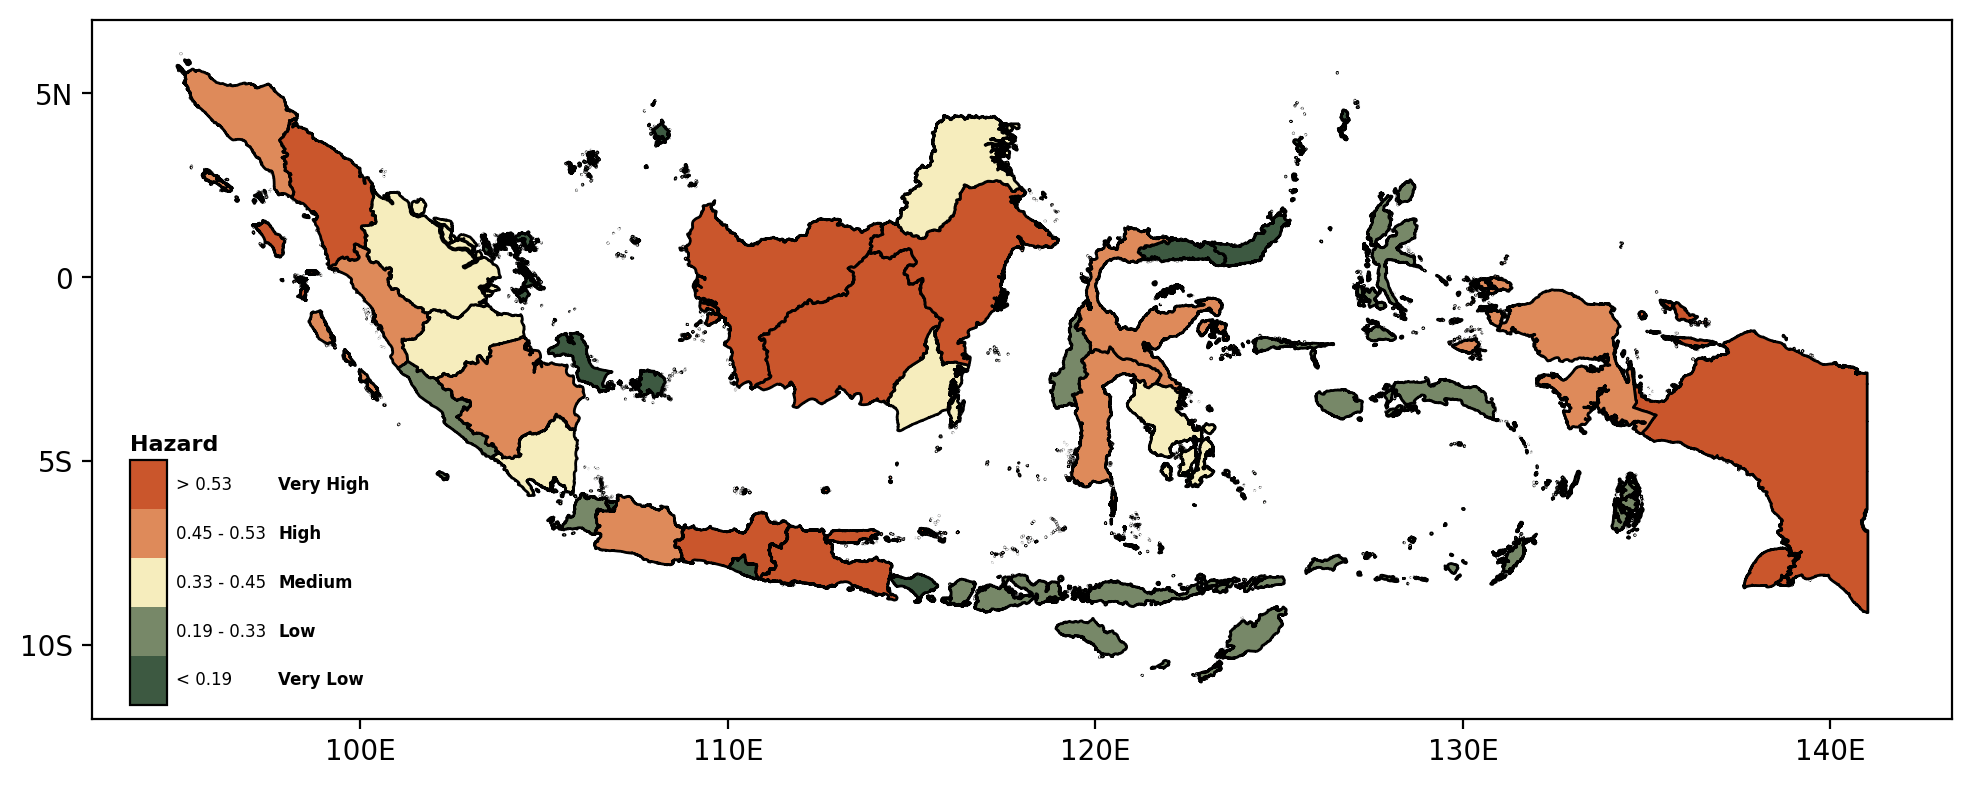

Hazard


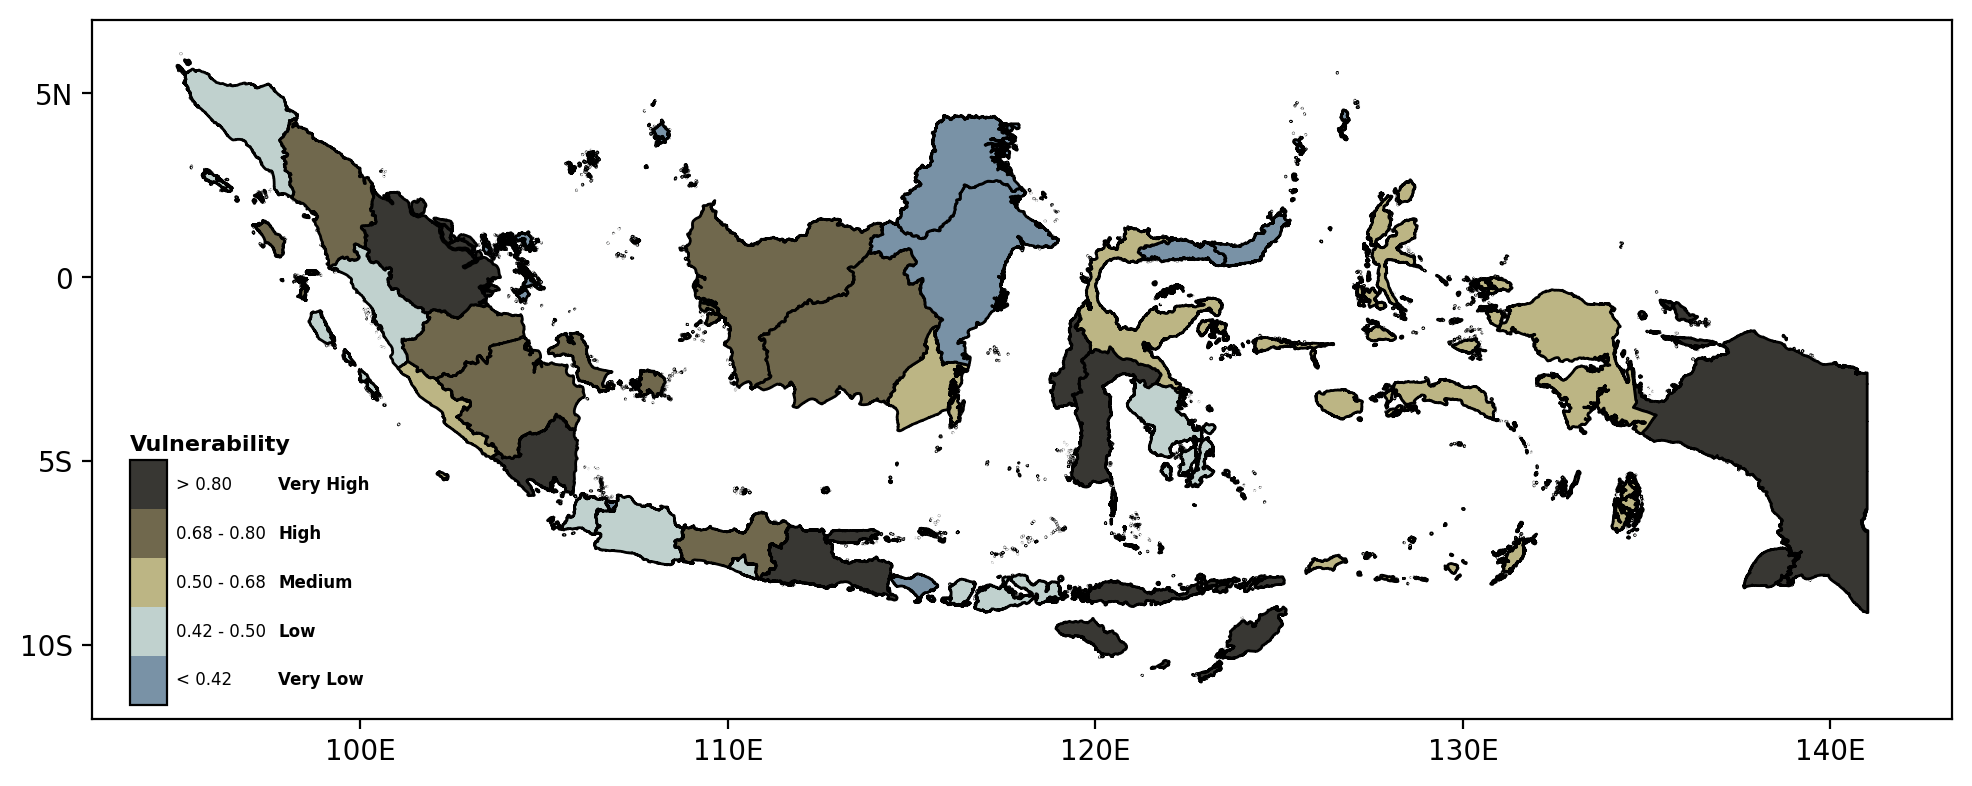

Vulnerability


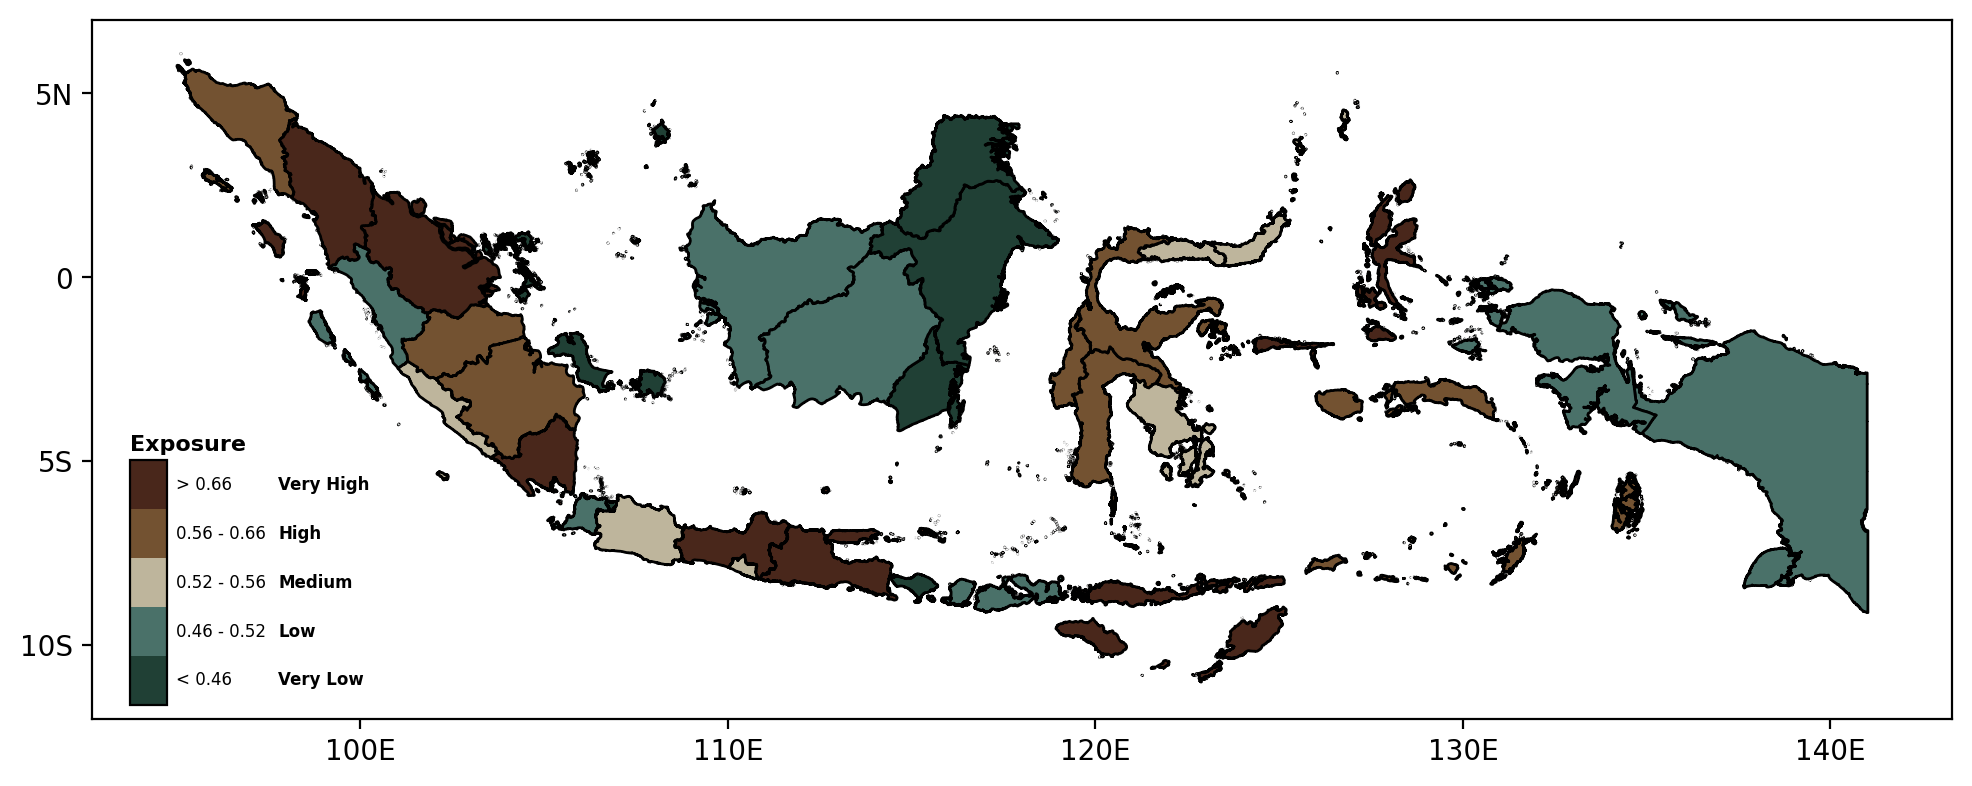

Exposure


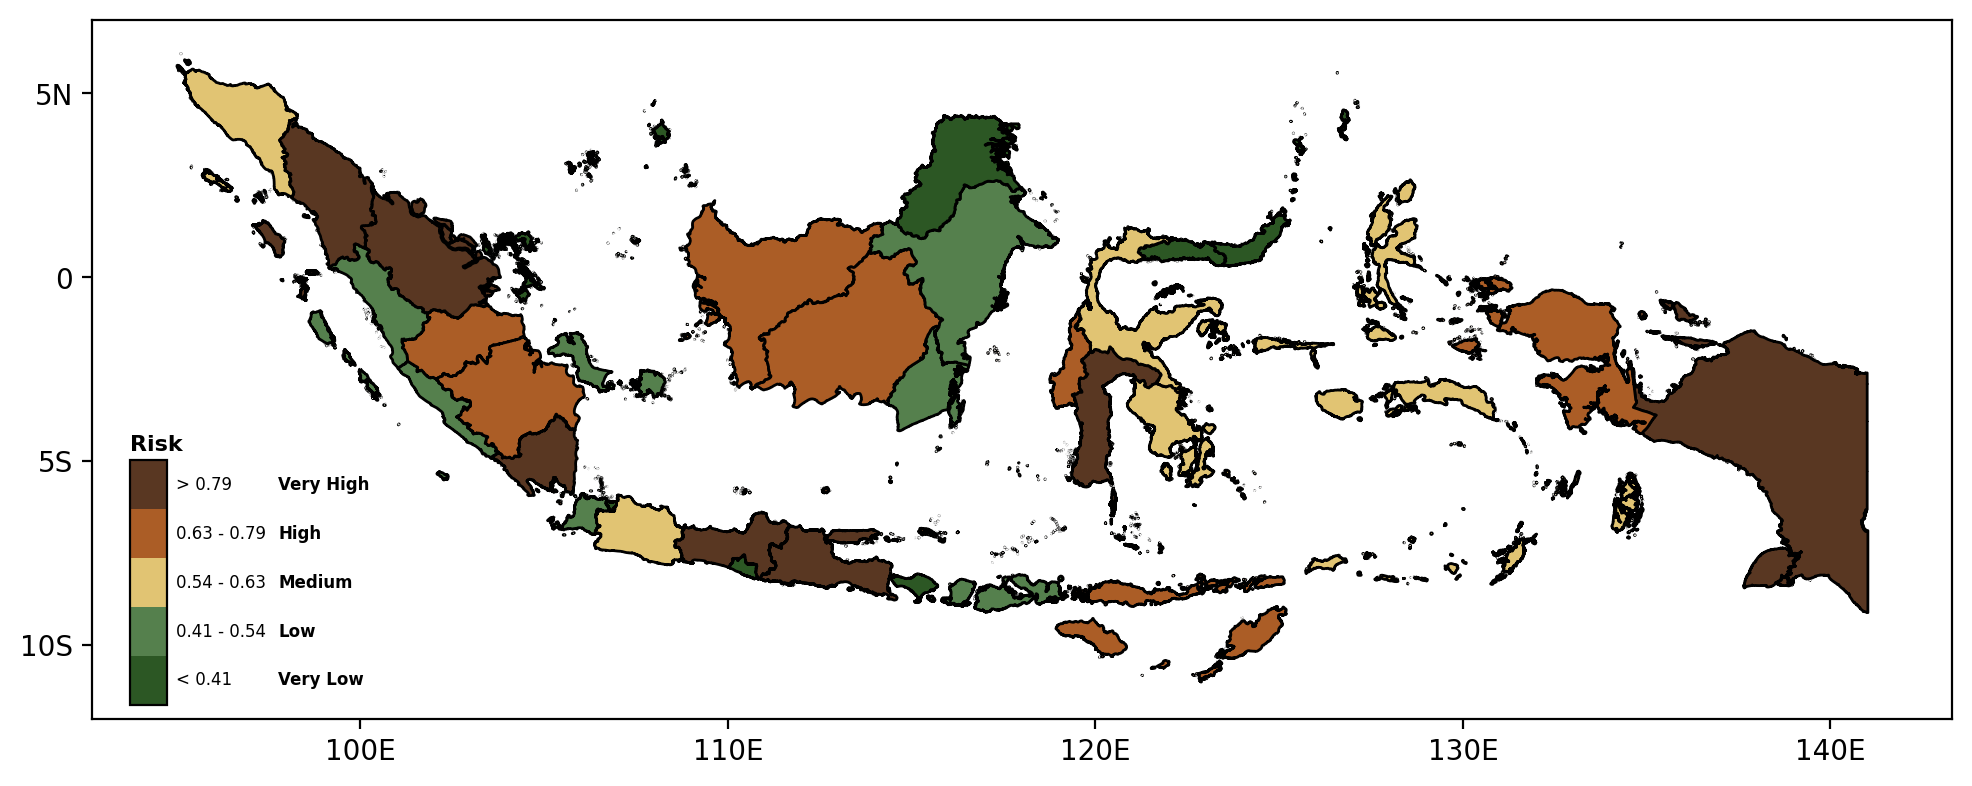

Risk


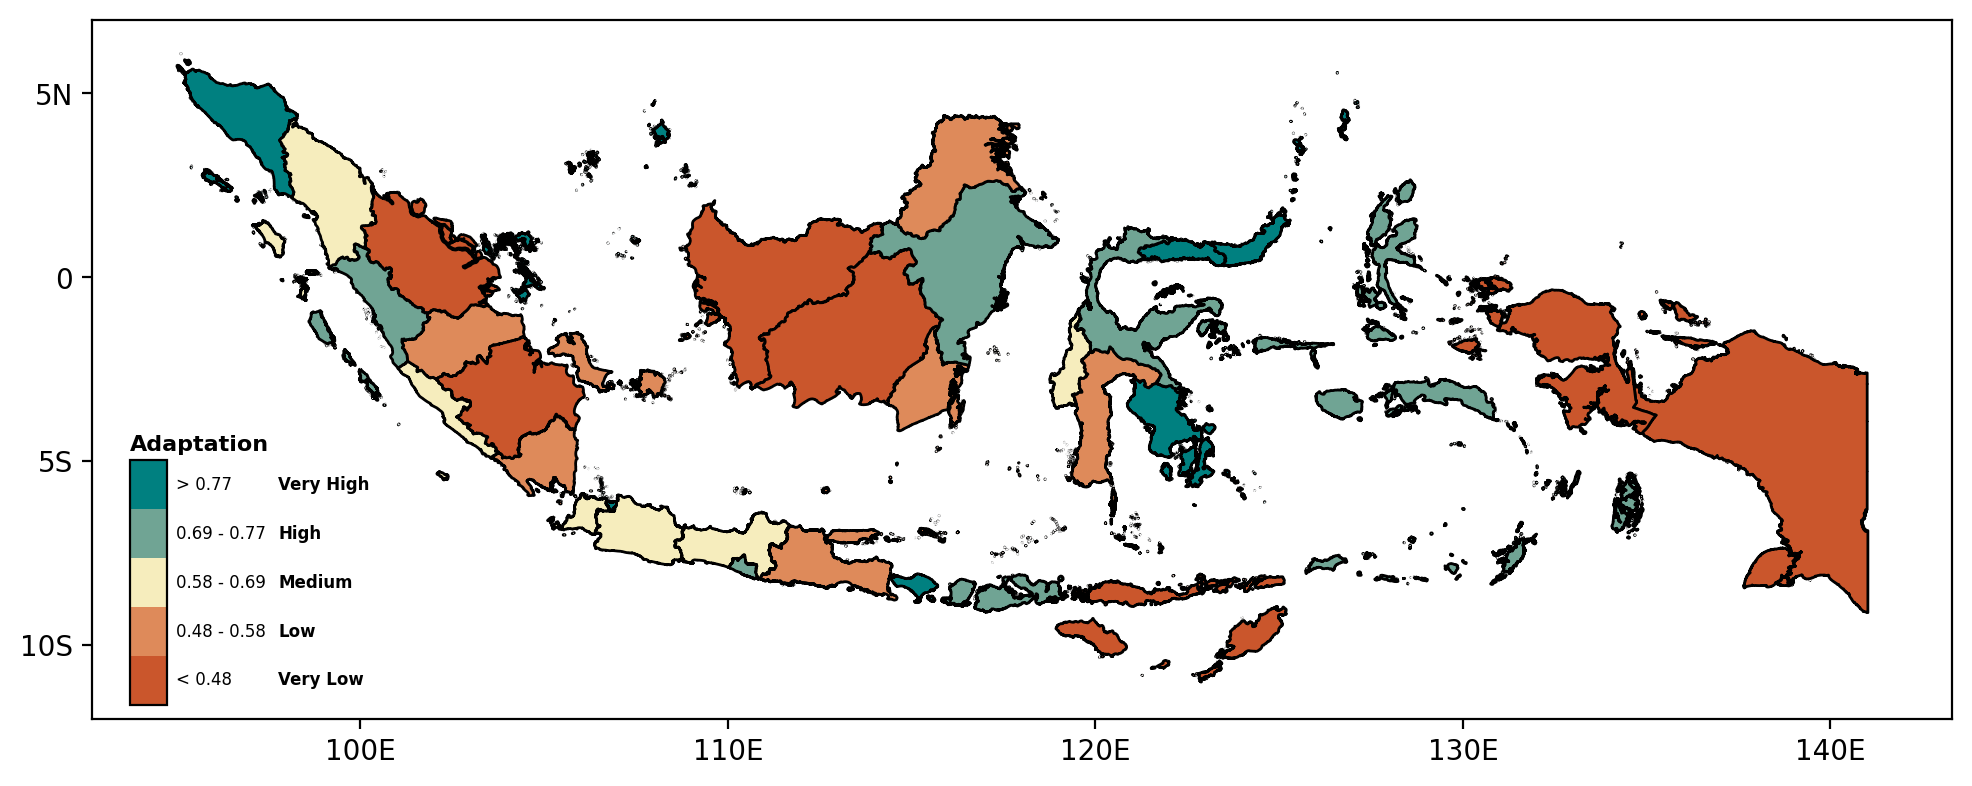

Adaptation


In [135]:
from matplotlib.colors import ListedColormap
import numpy as np


colormap = lambda x: ListedColormap(x(np.linspace(0, 1, 5)))

# alacena map

cmap_h = colormap(load_cmap("Fall")) #load_cmap("Alacena").reversed()
cmap_a = colormap(load_cmap("Geyser").reversed()) #load_cmap("OskarSchlemmer")

cmap_r = colormap(load_cmap("Ofrenda").reversed()) # "Earth"


config = {
    'Hazard':{'var':'H', 'cmap': cmap_h},
    'Vulnerability':{'var':'V', 'cmap':load_cmap("Alosa_fallax")},
    'Exposure':{'var':'E', 'cmap':load_cmap("C_M_Coolidge")},
    'Risk':{'var':'R', 'cmap':cmap_r},
    'Adaptation':{'var':'A', 'cmap':cmap_a}
}

for key, vals in config.items():
    _ = plot_map(dat, vals['var'], key, vals['cmap'])
    print(key)

In [162]:

config = {
    # 'Hazard':{'var':'H', 'cmap': cmap_h},
    # 'Vulnerability':{'var':'V', 'cmap':load_cmap("Alosa_fallax")},
    # 'Exposure':{'var':'E', 'cmap':load_cmap("C_M_Coolidge")},
    'Risk':{'var':'R', 'cmap':cmap_r},
    # 'Adaptation':{'var':'A', 'cmap':cmap_a}
}

# for key, vals in config.items():
#     _ = plot_map(dat, vals['var'], key, vals['cmap'])
#     print(key)

In [ ]:


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 3), nrows=1, ncols=3, 
                       dpi=200, constrained_layout=True, sharey=True)

bp_args = dict(patch_artist=True,return_type='dict', widths=0.4)

# Make the boxplots with patch_artist=True so boxes are Polygon patches
bp1 = data.boxplot(column='R', by='Region', ax=ax[0], **bp_args)
bp2 = data.boxplot(column='E', by='Region', ax=ax[1], **bp_args)
bp3 = data.boxplot(column='V', by='Region', ax=ax[2], **bp_args)

# colormap
from pypalettes import load_cmap


def color_boxes(bp, cmap):
    bp = bp.values[0]
    boxes = bp['boxes']
    n = len(boxes)
    colors = ["#DA5B43FF", "#53777AFF"]
    for patch, color in zip(boxes, colors):
        patch.set_facecolor(color)   # fill color
        patch.set_edgecolor("black") # box edge
        patch.set_alpha(1)

    # Style medians, whiskers, caps
    for median in bp['medians']:
        median.set_color("k")
        median.set_linewidth(1)

    for whisker in bp['whiskers']:
        whisker.set_color("black")

    for cap in bp['caps']:
        cap.set_color("black")
    
    for flier, color in zip(bp['fliers'], colors):
        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor("black")

# Apply
color_boxes(bp1, cmap)
color_boxes(bp2, cmap)
color_boxes(bp3, cmap)

# Labels
for i in range(3):
    ax[i].set_xlabel('')
    ax[i].set_title('')
    ax[i].grid(False)
    ax[i].invert_xaxis()

# Annotate

ax[0].text(1.5, 1, 'Risk', va='center', ha='center')
ax[1].text(1.5, 1, 'Exposure', va='center', ha='center')
ax[2].text(1.5, 1, 'Vulnerability', va='center', ha='center')
fig.suptitle('')
fig.savefig('result\Distribution_Region.png', dpi=200, bbox_inches='tight')
fig.savefig('result\Distribution_Region.svg', dpi=200, bbox_inches='tight')
plt.show()

In [168]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors

def plot_map_with_boxplots(dat, var, fname, cmap):
        
        # ===== Configuration =====
        cmap = cmap # colormap
        quantiles = data[var].quantile([0.2, 0.4, 0.6, 0.8]).values # quantile limit
        bounds = [0] + quantiles.tolist() + [1] 
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        edgecolor = 'k'

        # ===== Plotting =====
        fig, ax = plt.subplots(figsize=(12,6), dpi=200)
        im = dat.plot(column=var, legend=False, ax=ax, edgecolor=edgecolor, 
                        linewidth=1, cmap=cmap, norm=norm)

        # Create colorbar inside the axes
        cax = inset_axes(ax, width="2%", height="35%", loc='lower left', bbox_to_anchor=(0.02, 0.02, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
        cb = plt.colorbar(im.collections[0], cax=cax, boundaries=bounds, ticks=bounds, spacing='uniform', orientation='vertical')
        cb.set_ticks([])  # Remove default ticks
        color_centers = [(bounds[j] + bounds[j+1]) / 2 for j in range(len(bounds)-1)]


        cax2 = inset_axes(ax, width="20%", height="30%", loc='upper right', bbox_to_anchor=(-0.02, -0.02, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
        bp = data.boxplot(column=var, by='Region', ax=cax2, **bp_args)
        cax2.set_xlabel('')
        cax2.set_title('')
        cax2.grid(False)
        cax2.invert_xaxis()
        plt.title('')
        fig.suptitle('')
        
        def color_boxes(bp):
                bp = bp.values[0]
                boxes = bp['boxes']
                n = len(boxes)
                colors = ["#DA5B43FF", "#53777AFF"]
                for patch, color in zip(boxes, colors):
                        patch.set_facecolor(color)   # fill color
                        patch.set_edgecolor("black") # box edge
                        patch.set_alpha(1)

                # Style medians, whiskers, caps
                for median in bp['medians']:
                        median.set_color("k")
                        median.set_linewidth(1)

                for whisker in bp['whiskers']:
                        whisker.set_color("black")

                for cap in bp['caps']:
                        cap.set_color("black")
                
                for flier, color in zip(bp['fliers'], colors):
                        flier.set_markerfacecolor(color)
                        flier.set_markeredgecolor("black")

        color_boxes(bp)
        # Add labels above each color
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        quantile_text = [f"{f'< {bounds[1]:.2f}':<12.12}", 
                        f"{bounds[1]:.2f} - {bounds[2]:.2f}".ljust(12)[:12],
                        f"{bounds[2]:.2f} - {bounds[3]:.2f}".ljust(12)[:12],
                        f"{bounds[3]:.2f} - {bounds[4]:.2f}".ljust(12)[:12],
                        f"{f'> {bounds[4]:.2f}':<12.12}"]

        for i in range(5):
                cax.text(1.25, color_centers[i], rf"{quantile_text[i]}", ha='left', va='center', 
                        fontsize=6, transform=cax.transData)
                cax.text(4, color_centers[i], labels[i], ha='left', va='center', 
                        fontsize=6, transform=cax.transData, fontweight='bold')

        cb.ax.tick_params(axis='both', which='both', length=0)

        ax.set_ylim([-12, 7])
        ax.set_yticks([-10, -5, 0, 5])
        ax.set_yticklabels(["10S", "5S", "0", "5N"])
        ax.set_xticks([100, 110, 120, 130, 140])
        ax.set_xticklabels(["100E", "110E", "120E", "130E", "140E"])

        # Set the colorbar title at the top left corner of the colorbar (cax)
        cax.set_title(f'{fname}', fontweight='bold', fontsize=8, ha='left', va='bottom', loc='left', pad=2)
        fig.savefig(f"Map_{fname}_With_Boxplot.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"Map_{fname}_With_Boxplot.svg", dpi=300, bbox_inches='tight')
        plt.show()

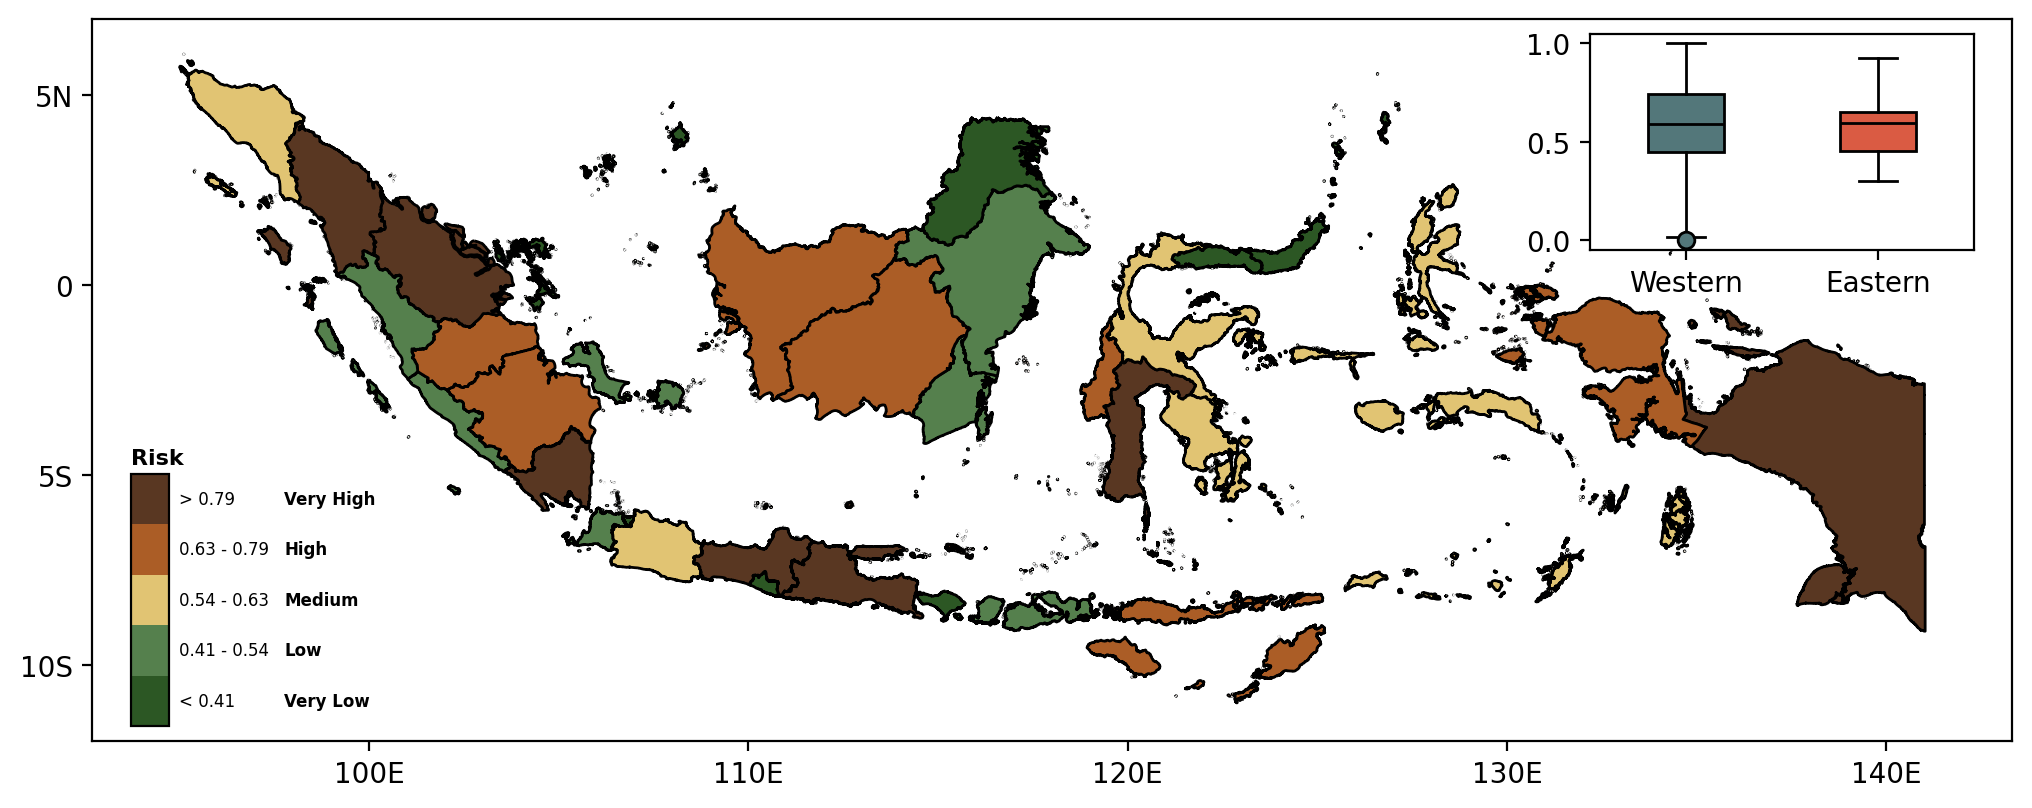

In [169]:
data['Region'] = data['Province'].map(region_map)
for key, vals in config.items():
    _ = plot_map_with_boxplots(dat, vals['var'], key, vals['cmap'])

### Risk vs Vulnerability Map

In [53]:
import mapclassify
import xycmap

In [54]:
data = indices[['province', 'R', 'V']].copy()


ncolors = 5

data['X'] = data[['R']].apply(mapclassify.Quantiles.make(rolling=True, k=ncolors)).values
data['Y'] = data[['V']].apply(mapclassify.Quantiles.make(rolling=True, k=ncolors)).values
data['XY'] = data['X'].astype(str) + "-" + data['Y'].astype(str)

data = shp.merge(data, right_on='province', left_on='PROVINSI')

In [55]:
colors = ["#1F83B4FF", "#12A2A8FF", "#2CA030FF", "#78A641FF", "#BCBD22FF", 
          "#FFBF50FF", "#FFAA0EFF", "#FF7F0EFF", "#D63A3AFF", "#C7519CFF", 
          "#BA43B4FF", "#8A60B0FF", "#6F63BBFF"] # classic cyclic

In [56]:
# 
# corner_colors = ("#F4E7C5FF", "#FF7F0EFF", "#12A2A8FF", "#8A60B0FF")
# n = (ncolors, ncolors)  # x, y
# cmap = xycmap.custom_xycmap(corner_colors=corner_colors, n=n)

# fig = plt.figure()
# cax = fig.add_axes([1, 0.25, 0.5, 0.5])
# cax = xycmap.bivariate_legend(ax=cax, sx=data['R'], sy=data['V'], cmap=cmap)

corner_colors = ("#F4E7C5FF", "#979461FF", "#678096FF", "#A12A19FF")
n = (ncolors, ncolors)  # x, y
cmap = xycmap.custom_xycmap(corner_colors=corner_colors, n=n)

In [57]:
color_mapping = {}

for i in range(ncolors):
    for j in range(ncolors):
        color_mapping[f'{i}-{j}'] = cmap[i, j]

C:\Users\binta\AppData\Local\Temp\ipykernel_20928\2924492841.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  im = data.plot(column = "XY",


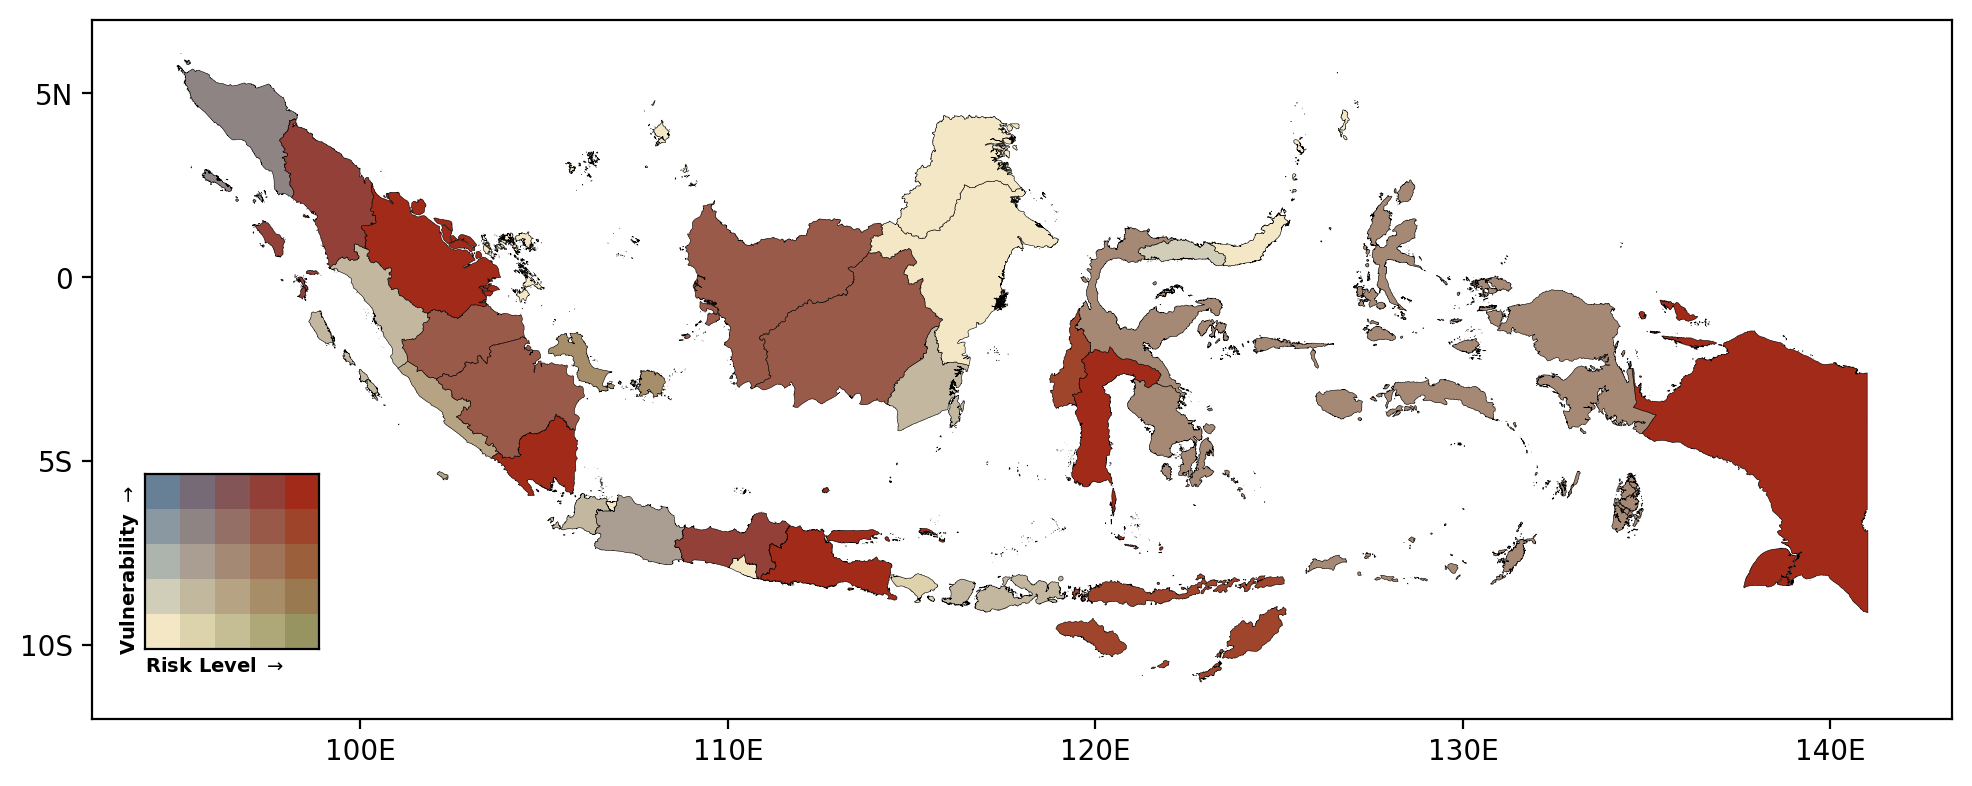

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(figsize=(12,6), dpi=200)

im = data.plot(column = "XY", 
               categorical = True,
               edgecolor = "k",
               linewidth = 0.2,
               ax = ax,
               color=data["XY"].map(color_mapping))

# create colorbar inside the axes
cax = inset_axes(ax, width="25%", height="25%", loc='lower left', bbox_to_anchor=(-0.05, 0.1, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cb = xycmap.bivariate_legend(ax=cax, sx=data['R'], sy=data['V'], cmap=cmap, 
                             xlabels=['', '', '', '', '', ''], ylabels=['', '', '', '', '', ''])
cb.tick_params(axis='both', which='both', length=0)
cb.label_outer([])

cax.text(-0.5,-1, r'Risk Level $\rightarrow$', ha='left', va='center', 
            fontsize=7, transform=cax.transData, fontweight='bold')
cax.text(-1.25,1.75, r'Vulnerability $\rightarrow$', ha='left', va='center', 
            fontsize=7, transform=cax.transData, fontweight='bold', rotation=90)

ax.set_ylim([-12, 7])
ax.set_yticks([-10, -5, 0, 5])
ax.set_yticklabels(["10S", "5S", "0", "5N"])
ax.set_xticks([100, 110, 120, 130, 140])
ax.set_xticklabels(["100E", "110E", "120E", "130E", "140E"])
cax.set_axis_on()
fig.savefig('result\Risk_And_Vulnerability.png',dpi=200, bbox_inches='tight')
fig.savefig('result\Risk_And_Vulnerability.svg',dpi=200, bbox_inches='tight')
    
plt.show()

### Risk vs Vulnerability Table

In [75]:
data = indices.copy()

In [70]:
data = set_category(data, 'R', col='Risk Level')
data = set_category(data, 'V', col='Vulnerability Level')

In [71]:
data = data[['Province', 'Risk Level', 'Vulnerability Level']].copy()

In [72]:
rv_data = data.groupby(['Risk Level', 'Vulnerability Level'])['Province'].agg(', '.join).reset_index()

In [73]:
rv_data

,Risk Level,Vulnerability Level,Province
0,High,High,"Jambi, Kalimantan Barat, Kalimantan Tengah, Su..."
1,High,Medium,Papua Barat
2,High,Very High,"Nusa Tenggara Timur, Sulawesi Barat"
3,Low,High,Bangka Belitung
4,Low,Low,"Banten, Nusa Tenggara Barat, Sumatera Barat"
5,Low,Medium,"Bengkulu, Kalimantan Selatan"
6,Low,Very Low,Kalimantan Timur
7,Medium,Low,"Aceh, Jawa Barat, Sulawesi Tenggara"
8,Medium,Medium,"Maluku, Maluku Utara, Sulawesi Tengah"
9,Very High,High,"Jawa Tengah, Sumatera Utara"


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.colors as mcolors

# Calculate quantiles for 'H'
quantiles = data['H'].quantile([0.2, 0.4, 0.6, 0.8]).values

# Define 5 colors for 5 quantile bins
from pypalettes import load_cmap
cmap = load_cmap("Atentado")

cmap = load_cmap("BarnettNewman")

cmap = load_cmap("CafeDeNuit")

cmap = load_cmap("CafeTerrace")
cmap = load_cmap("Alosa_fallax")
cmap = load_cmap("CharlesDemuth")




bounds = [0] + quantiles.tolist() + [1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(12,6), dpi=200)
data = shp.merge(hazard, left_on='PROVINSI', right_on='province')
im = data.plot(column='H', legend=False, ax=ax, edgecolor='black', linewidth=1, cmap=cmap, norm=norm)

# Create colorbar inside the axes
cax = inset_axes(ax, width="2%", height="35%", loc='lower left', bbox_to_anchor=(0.02, 0.02, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cb = plt.colorbar(im.collections[0], cax=cax, boundaries=bounds, ticks=bounds, spacing='uniform', orientation='vertical')
cb.set_ticks([])  # Remove default ticks
color_centers = [(bounds[j] + bounds[j+1]) / 2 for j in range(len(bounds)-1)]

# Add labels above each color
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
quantile_text = [f"{f'< {bounds[1]:.2f}':<12.12}", 
                 f"{bounds[1]:.2f} - {bounds[2]:.2f}".ljust(12)[:12],
                 f"{bounds[2]:.2f} - {bounds[3]:.2f}".ljust(12)[:12],
                 f"{bounds[3]:.2f} - {bounds[4]:.2f}".ljust(12)[:12],
                 f"{f'> {bounds[4]:.2f}':<12.12}"]

for i in range(5):
    cax.text(1.25, color_centers[i], rf"{quantile_text[i]}", ha='left', va='center', 
            fontsize=6, transform=cax.transData)
    cax.text(4, color_centers[i], labels[i], ha='left', va='center', 
            fontsize=6, transform=cax.transData, fontweight='bold')
    
cb.ax.tick_params(axis='both', which='both', length=0)

# 
ax.set_ylim([-12, 7])
ax.set_yticks([-10, -5, 0, 5])
ax.set_yticklabels(["10S", "5S", "0", "5N"])
ax.set_xticks([100, 110, 120, 130, 140])
ax.set_xticklabels(["100E", "110E", "120E", "130E", "140E"])
# Set the colorbar title at the top left corner of the colorbar (cax)
cax.set_title('Hazard', fontweight='bold', fontsize=8, ha='left', va='bottom', loc='left', pad=2)
fig.savefig('result\Hazard.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=200, constrained_layout=True, 
                       nrows=7, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()


for i, p in enumerate(provinces):

    # Fix: use the actual province name, not the string 'p'
    subset = tmax.loc[tmax['province'] == p, ['year', 'tmax']]
    ax[i+1].plot(subset.year, subset.tmax, color='tab:red')
    ax[i+1].fill_between(subset.year, subset.tmax, color='tab:red', alpha=0.2)

    ax[i+1].text(1997, 40, p)
    ax[i+1].set_yticks([25, 35, 45])


# indonesia average
tmax_idn = tmax.groupby(['year'])['tmax'].mean().reset_index()
ax[0].plot(tmax_idn.year, tmax_idn.tmax, color='tab:red')
ax[0].fill_between(tmax_idn.year, tmax_idn.tmax, color='tab:red', alpha=0.2)
ax[0].text(1997, 40, 'Average')


for i in range(35):
    ax[i].set_xlim([1995, 2024])
    ax[i].set_ylim([25, 50])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].tick_params(axis='both', which='both', length=0)
    if i not in [0, 5, 10, 15, 20, 25, 30]:
        ax[i].spines['left'].set_visible(False)

ax[32].set_xlabel('Year')
ax[15].set_ylabel(r'Tmax ($^o$C)')
fig.suptitle('Maximum Temperature', fontweight='bold', fontsize=16, ha='left', x=0.02)
fig.savefig('result\Hazard_Tmax.png', dpi=200, bbox_inches='tight')
plt.show()

In [259]:
from pypalettes import load_cmap
cmap = load_cmap("superb_fairy_wren")

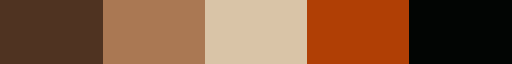

In [260]:
cmap

## PCA

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bartlett
from factor_analyzer.factor_analyzer import calculate_kmo

In [84]:
num_cols = ['H' + str(n) for n in range(1, 8)]
hazard_data = indices[['Province'] + num_cols]

Correlation Matrix:
       H1     H2     H3     H4     H5     H6     H7
H1  1.000  0.589  0.695  0.610  0.564 -0.666  0.629
H2  0.589  1.000  0.277  0.282  0.254 -0.173  0.048
H3  0.695  0.277  1.000  0.960  0.868 -0.716  0.761
H4  0.610  0.282  0.960  1.000  0.948 -0.624  0.711
H5  0.564  0.254  0.868  0.948  1.000 -0.554  0.679
H6 -0.666 -0.173 -0.716 -0.624 -0.554  1.000 -0.852
H7  0.629  0.048  0.761  0.711  0.679 -0.852  1.000


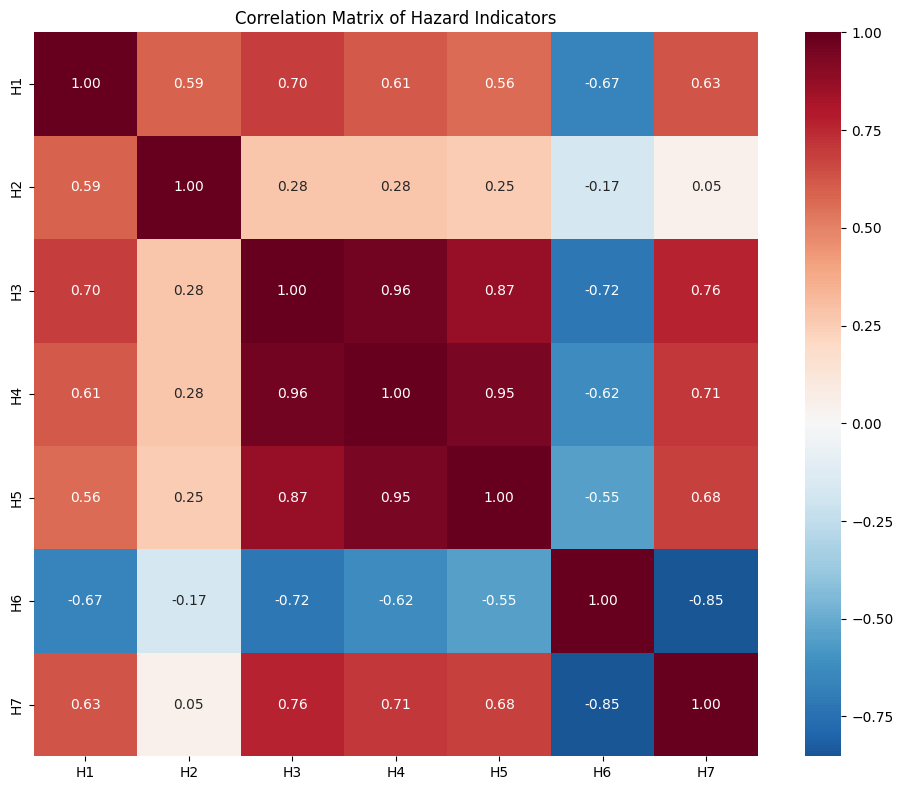


Significant Correlations (|r| > 0.3):
H1 vs H2: 0.589
H1 vs H3: 0.695
H1 vs H4: 0.610
H1 vs H5: 0.564
H1 vs H6: -0.666
H1 vs H7: 0.629
H3 vs H4: 0.960
H3 vs H5: 0.868
H3 vs H6: -0.716
H3 vs H7: 0.761
H4 vs H5: 0.948
H4 vs H6: -0.624
H4 vs H7: 0.711
H5 vs H6: -0.554
H5 vs H7: 0.679
H6 vs H7: -0.852


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bartlett
from factor_analyzer.factor_analyzer import calculate_kmo

hazard_vars = hazard_data.iloc[:, 1:] 

# 1. Calculate correlation matrix
correlation_matrix = hazard_vars.corr()
print("Correlation Matrix:")
print(correlation_matrix.round(3))

# 2. Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f')
plt.title('Correlation Matrix of Hazard Indicators')
plt.tight_layout()
plt.show()

# 3. Check for significant correlations
print("\nSignificant Correlations (|r| > 0.3):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.3:
            print(f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}: {corr:.3f}")

In [100]:
# Bartlett's Test
chi_square_value, p_value = bartlett(*hazard_vars.values.T)  # Note: .T for transpose
print(f"Bartlett's Test of Sphericity:")
print(f"Chi-square: {chi_square_value:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✓ GOOD: Variables are sufficiently correlated for PCA (p < 0.05)")
else:
    print("✗ WARNING: Variables may not be correlated enough for PCA (p >= 0.05)")

Bartlett's Test of Sphericity:
Chi-square: 21.2125
P-value: 0.0017
✓ GOOD: Variables are sufficiently correlated for PCA (p < 0.05)


In [88]:
# KMO Test - you may need to install: pip install factor-analyzer
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(hazard_vars)
print(f"\nKMO Test:")
print(f"Overall KMO: {kmo_model:.4f}")

# KMO for individual variables
kmo_per_variable = pd.DataFrame({
    'Variable': hazard_vars.columns,
    'KMO': kmo_all
})
print("\nKMO per variable:")
print(kmo_per_variable.round(4))

# Interpretation
if kmo_model > 0.80:
    print("✓ EXCELLENT: KMO > 0.80 - Highly suitable for PCA")
elif kmo_model > 0.70:
    print("✓ GOOD: KMO > 0.70 - Suitable for PCA")  
elif kmo_model > 0.50:
    print("✓ ACCEPTABLE: KMO > 0.50 - Barely acceptable for PCA")
else:
    print("✗ UNACCEPTABLE: KMO <= 0.50 - Not suitable for PCA")


KMO Test:
Overall KMO: 0.7052

KMO per variable:
  Variable     KMO
0       H1  0.7029
1       H2  0.4104
2       H3  0.7025
3       H4  0.6490
4       H5  0.7230
5       H6  0.8271
6       H7  0.7949
✓ GOOD: KMO > 0.70 - Suitable for PCA


c:\Users\binta\AppData\Local\Programs\Python\Python312\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [90]:
# Run PCA on just your 7 hazards
pca_hazard = PCA()
hazard_components = pca_hazard.fit_transform(StandardScaler().fit_transform(hazard_vars))

In [91]:
pca_df = pd.DataFrame(data=hazard_components, 
                     columns=[f'PC{i+1}' for i in range(hazard_vars.shape[1])])
pca_df['Province'] = hazard_data['Province']

In [94]:
explained_variance = pca_hazard.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

In [97]:
print("Explained variance per PC:", explained_variance)
print("Cumulative variance:", cumulative_variance)

Explained variance per PC: [0.67774994 0.16128067 0.0997251  0.02755406 0.0198626  0.01220831
 0.00161933]
Cumulative variance: [0.67774994 0.8390306  0.9387557  0.96630976 0.98617236 0.99838067
 1.        ]


In [98]:
loadings = pca_hazard.components_.T * np.sqrt(pca_hazard.explained_variance_)
loadings_df = pd.DataFrame(loadings,
                          columns=[f'PC{i+1}' for i in range(hazard_vars.shape[1])],
                          index=hazard_vars.columns)

In [99]:
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
H1,0.821746,0.401622,-0.279635,0.333798,-0.021240,0.059561,0.010986
H2,0.381527,0.916696,0.022516,-0.192718,0.065664,-0.049183,-0.005514
H3,0.965382,-0.082508,0.178562,0.031647,-0.192330,-0.135243,-0.058011
H4,0.940447,-0.086950,0.354075,-0.031278,-0.060541,-0.037079,0.083158
H5,0.892926,-0.100274,0.413385,-0.010029,0.144807,0.172442,-0.035189
H6,-0.834968,0.172046,0.474064,0.218966,0.128998,-0.119162,-0.002960
H7,0.869652,-0.327904,-0.296056,-0.011639,0.245404,-0.135941,-0.000204
